In [2]:

import copy
import pickle
import random

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm, trange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data


import torch_geometric as pyg
import torch_geometric.data as pyg_data
from torch_geometric.typing import Adj, OptTensor
import torch_sparse

In [4]:
events = pd.read_csv('events.csv')
print(events.head())

       timestamp  visitorid event  itemid  transactionid
0  1433221332117     257597  view  355908            NaN
1  1433224214164     992329  view  248676            NaN
2  1433221999827     111016  view  318965            NaN
3  1433221955914     483717  view  253185            NaN
4  1433221337106     951259  view  367447            NaN


In [4]:
events.describe()

,timestamp,visitorid,itemid,transactionid
count,2.756101e+06,2.756101e+06,2.756101e+06,22457.000000
mean,1.436424e+12,7.019229e+05,2.349225e+05,8826.497796
std,3.366312e+09,4.056875e+05,1.341954e+05,5098.996290
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000
50%,1.436453e+12,7.020600e+05,2.360670e+05,8813.000000
75%,1.439225e+12,1.053437e+06,3.507150e+05,13224.000000
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000


In [5]:
max(events['itemid'])

466867

In [5]:
# Filter only the 'view' events.
view_events = events[events['event'] == 'view']
print( {len(view_events)})

{2664312}


In [6]:
# Filter out visitors with single clicks.
visits_per_visitor = view_events['visitorid'].value_counts(dropna=False)
visits_per_visitor.head()

filtered_visits_of_visitors = visits_per_visitor[
    visits_per_visitor > 1
].index
view_events = view_events[
    view_events['visitorid'].isin(filtered_visits_of_visitors)]

In [7]:
# Let's group events and their timing data.
visits_data = {}
for _, row in enumerate(tqdm(view_events.iterrows())):
    timestamp, visitorid, event, itemid, transactionid = row[1].values

    if visitorid not in visits_data:
        visits_data[visitorid] = {'itemids': [], 'timestamps': []}
    visits_data[visitorid]['itemids'].append(itemid)
    visits_data[visitorid]['timestamps'].append(timestamp)

print(f'There are {len(visits_data)} visitors left.')

1656582it [00:41, 39814.70it/s]

There are 396449 visitors left.


In [8]:
# We will separate sessions by 1 hr.
session_gap = 1 * 3600 * 1000

# Let's group events from visitors into sessions.
sessions_of_visitors = {}
for visitorid, visitor_dict in visits_data.items():
    sessions = [[]]
    sorted_events = sorted(zip(visitor_dict['timestamps'],
                               visitor_dict['itemids']))
    for i in range(len(sorted_events) - 1):
        sessions[-1].append(sorted_events[i][1])
        if (sorted_events[i+1][0] - sorted_events[i][0]) > session_gap:
            sessions.append([])
    sessions[-1].append(sorted_events[len(sorted_events) - 1][1])
    sessions_of_visitors[visitorid] = sessions

print({len(sessions_of_visitors)})

{396449}


In [9]:
# Adjsut sampling rate ([0, 1]) to generate smaller datasets.
# Setting `sampling_rate` to 1 will lead to a full dataset split.
sampling_rate = 1

# We use random seed for reproducibility.
seed = 42
all_visitors = list(sessions_of_visitors.keys())
random.Random(seed).shuffle(all_visitors)

num_train = int(len(all_visitors) * 0.8 * sampling_rate)
num_val = int(len(all_visitors) * 0.1 * sampling_rate)
num_test = int(len(all_visitors) * 0.1 * sampling_rate)

train_visitors = all_visitors[:num_train]
val_visitors = all_visitors[num_train : num_train+num_val]
test_visitors = all_visitors[num_train+num_val:num_train+num_val+num_test]

In [10]:
def extract_subsessions(sessions):
    all_sessions = []
    for session in sessions:
        for i in range(1, len(session)):
            all_sessions.append(session[:i+1])
    return all_sessions

In [11]:
# Check the number of visitors in each split
print(f'train, val, and test visitors: {len(train_visitors), len(val_visitors), len(test_visitors)}')

train_sessions, val_sessions, test_sessions = [], [], []
for visitor in train_visitors:
    train_sessions.extend(extract_subsessions(sessions_of_visitors[visitor]))
for visitor in val_visitors:
    val_sessions.extend(extract_subsessions(sessions_of_visitors[visitor]))
for visitor in test_visitors:
    test_sessions.extend(extract_subsessions(sessions_of_visitors[visitor]))

train, val, and test visitors: (317159, 39644, 39644)


In [12]:
# Check the number of (sub)sessions in each split
print(f'train, val, and test sessions: {len(train_sessions), len(val_sessions), len(test_sessions)}')

# Save the processed files.
with open('raw/train.txt', 'wb') as f:
    pickle.dump(train_sessions, f)
with open('raw/val.txt', 'wb') as f:
    pickle.dump(val_sessions, f)
with open('raw/test.txt', 'wb') as f:
    pickle.dump(test_sessions, f)

train, val, and test sessions: (759943, 88625, 93999)


In [13]:
class GraphDataset(pyg_data.InMemoryDataset):
    def __init__(self, root, file_name, transform=None, pre_transform=None):
        self.file_name = file_name
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return [f'{self.file_name}.txt']

    @property
    def processed_file_names(self):
        return [f'{self.file_name}.pt']

    def download(self):
        pass

    def process(self):
        raw_data_file = f'{self.raw_dir}/{self.raw_file_names[0]}'
        with open(raw_data_file, 'rb') as f:
            sessions = pickle.load(f)
        data_list = []

        for session in sessions:
            session, y = session[:-1], session[-1]
            codes, uniques = pd.factorize(session)
            senders, receivers = codes[:-1], codes[1:]

            edge_index = torch.tensor(np.array([senders, receivers]))
            x = torch.tensor(uniques, dtype=torch.long).unsqueeze(1)
            y = torch.tensor([y], dtype=torch.long)
            data_list.append(pyg_data.Data(x=x, edge_index=edge_index, y=y))

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [14]:
class GatedSessionGraphConv(pyg.nn.conv.MessagePassing):
    def __init__(self, out_channels, aggr: str = 'add', **kwargs):
        super().__init__(aggr=aggr, **kwargs)

        self.out_channels = out_channels

        self.gru = torch.nn.GRUCell(out_channels, out_channels, bias=False)

    def forward(self, x, edge_index):
        m = self.propagate(edge_index, x=x, size=None)
        x = self.gru(m, x)
        return x

    def message(self, x_j):
        return x_j

    def message_and_aggregate(self, adj_t, x):
        return matmul(adj_t, x, reduce=self.aggr)

In [15]:
class SRGNN(nn.Module):
    def __init__(self, hidden_size, n_items):
        super(SRGNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_items = n_items

        self.embedding = nn.Embedding(self.n_items, self.hidden_size)
        self.gated = GatedSessionGraphConv(self.hidden_size)

        self.q = nn.Linear(self.hidden_size, 1)
        self.W_1 = nn.Linear(self.hidden_size, self.hidden_size, bias=False)
        self.W_2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.W_3 = nn.Linear(2 * self.hidden_size, self.hidden_size, bias=False)

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, data):
        x, edge_index, batch_map = data.x, data.edge_index, data.batch

        embedding = self.embedding(x).squeeze()

        v_i = self.gated(embedding, edge_index)

        sections = list(torch.bincount(batch_map).cpu())
        v_i_split = torch.split(v_i, sections)

        v_n, v_n_repeat = [], []
        for session in v_i_split:
            v_n.append(session[-1])
            v_n_repeat.append(
                session[-1].view(1, -1).repeat(session.shape[0], 1))
        v_n, v_n_repeat = torch.stack(v_n), torch.cat(v_n_repeat, dim=0)

        q1 = self.W_1(v_n_repeat)
        q2 = self.W_2(v_i)

        #creating global Embedding
        alpha = self.q(F.sigmoid(q1 + q2))
        s_g_split = torch.split(alpha * v_i, sections)

        s_g = []
        for session in s_g_split:
            s_g_session = torch.sum(session, dim=0)
            s_g.append(s_g_session)
        s_g = torch.stack(s_g)

        s_l = v_n # local Embedding
        s_h = self.W_3(torch.cat([s_l, s_g], dim=-1))

        z = torch.mm(self.embedding.weight, s_h.T).T
        return z

In [17]:
import torch
print(torch.__version__)
print(torch.backends.cudnn.enabled)


2.6.0+cu126
True


In [18]:
import sys
print(sys.executable)


C:\Users\USER\Desktop\ML viva\.venv\Scripts\python.exe


In [19]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


PyTorch Version: 2.6.0+cu126
CUDA Available: True
CUDA Version: 12.6
GPU Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [20]:
# hyperparameters.
args = {
    'batch_size': 128,
    'hidden_dim': 64,
    'epochs': 10,
    'l2_penalty': 0.0001,
    'weight_decay': 0.1,
    'step': 5,
    'lr': 0.001,
    'num_items': 466868}

class objectview(object):
    def __init__(self, d): 
        self.__dict__ = d

args = objectview(args)

In [21]:
print("w")

w


In [16]:
def train(args):
    # Prepare data pipeline
    train_dataset = GraphDataset('./', 'train')
    train_loader = pyg_data.DataLoader(train_dataset,
                                       batch_size=args.batch_size,
                                       shuffle=False,
                                       drop_last=True)
    val_dataset = GraphDataset('./', 'val')
    val_loader = pyg_data.DataLoader(val_dataset,
                                     batch_size=args.batch_size,
                                     shuffle=False,
                                     drop_last=True)

    device = torch.device("cuda")

    # Build model
    model = SRGNN(args.hidden_dim, args.num_items).to(device)

    # Get training components
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=args.lr,
                                 weight_decay=args.l2_penalty)
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step,
                                          gamma=args.weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Train
    losses = []
    test_accs = []
    top_k_accs = []

    best_acc = 0
    best_model = None

    for epoch in range(args.epochs):
        total_loss = 0
        model.train()
        for _, batch in enumerate(tqdm(train_loader)):
            batch.to(device)
            optimizer.zero_grad()

            pred = model(batch)
            label = batch.y
            loss = criterion(pred, label)

            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch.num_graphs

        total_loss /= len(train_loader.dataset)
        losses.append(total_loss)

        scheduler.step()

        if epoch % 1 == 0:
          test_acc, top_k_acc = test(val_loader, model, is_validation=True)
          print(test_acc)
          test_accs.append(test_acc)
          top_k_accs.append(top_k_acc)
          if test_acc > best_acc:
            best_acc = test_acc
            best_model = copy.deepcopy(model)
        else:
          test_accs.append(test_accs[-1])
  
    return test_accs, top_k_accs, losses, best_model, best_acc, val_loader

In [25]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

def precision_at_k(predictions, labels, k):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    hits = (top_k_preds == labels[:, None]).sum(axis=1)
    return hits.mean()

def recall_at_k(predictions, labels, k):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    hits = (top_k_preds == labels[:, None]).sum(axis=1)
    return hits.mean()

def mean_reciprocal_rank(predictions, labels):
    recip_ranks = []
    for i in range(predictions.shape[0]):
        pred = predictions[i]
        rank = np.where(pred.argsort()[::-1] == labels[i])[0][0]
        recip_ranks.append(1.0 / (rank + 1))
    return np.mean(recip_ranks)

def ndcg_at_k(predictions, labels, k):
    def dcg(scores):
        return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))

    ndcg_scores = []
    for i in range(predictions.shape[0]):
        pred = predictions[i]
        true_relevance = np.zeros(pred.shape)
        true_relevance[labels[i]] = 1
        ranked_relevance = true_relevance[pred.argsort()[::-1]]
        ideal_relevance = np.sort(true_relevance)[::-1]
        ndcg_scores.append(dcg(ranked_relevance[:k]) / dcg(ideal_relevance[:k]))
    return np.mean(ndcg_scores)

def diversity(predictions, k):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    unique_items = np.unique(top_k_preds)
    return len(unique_items) / (predictions.shape[0] * k)

def save_checkpoint(epoch, data, filename='checkpoint.pth.tar'):
    torch.save({'epoch': epoch, 'data': data}, filename)

def test(loader, test_model, is_validation=False, save_model_preds=False, item_popularity=None, checkpoint_interval=10):
    test_model.eval()

    # Define K for metrics.
    k = 10
    correct = 0
    top_k_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []
    all_scores = []

    batch_count = 0

    for idx, data in enumerate(tqdm(loader)):
        try:
            data = data.to('cuda')
            with torch.no_grad():
                score = test_model(data)
                pred = score.max(dim=1)[1]
                label = data.y

            if save_model_preds:
                all_preds.extend(pred.view(-1).cpu().detach().numpy())
                all_labels.extend(label.view(-1).cpu().detach().numpy())
                all_scores.extend(score.cpu().detach().numpy())

            correct += pred.eq(label).sum().item()
            total_samples += label.size(0)

            if not is_validation:
                score = score.cpu().detach().numpy()
                for row in range(pred.size(0)):
                    top_k_pred = np.argpartition(score[row], -k)[-k:]
                    if label[row].item() in top_k_pred:
                        top_k_correct += 1

            # Save checkpoint
            if save_model_preds and (idx + 1) % checkpoint_interval == 0:
                save_checkpoint(idx + 1, {
                    'pred': all_preds,
                    'label': all_labels,
                    'score': all_scores
                })
                # Clear intermediate results to free up memory
                all_preds = []
                all_labels = []
                all_scores = []

            # Clear CUDA cache to free up memory
            torch.cuda.empty_cache()

            batch_count += 1
            if batch_count % 10 == 0:
                print(f"Processed {batch_count} batches")

        except Exception as e:
            print(f"Error processing batch: {e}")
            torch.cuda.empty_cache()

    if save_model_preds:
        data = {
            'pred': all_preds,
            'label': all_labels,
            'score': all_scores
        }
        df = pd.DataFrame(data=data)
        df.to_csv('pred.csv', sep=',', index=False)

    if not is_validation:
        all_scores = np.array(all_scores)
        all_labels = np.array(all_labels)
        precision_k = precision_at_k(all_scores, all_labels, k)
        recall_k = recall_at_k(all_scores, all_labels, k)
        mrr = mean_reciprocal_rank(all_scores, all_labels)
        ndcg_k = ndcg_at_k(all_scores, all_labels, k)
        diversity_score = diversity(all_scores, k)

        return {
            'hit_rate': correct / total_samples,
            'hit_rate@k': top_k_correct / total_samples,
            'precision@k': precision_k,
            'recall@k': recall_k,
            'mrr': mrr,
            'ndcg@k': ndcg_k,
            'diversity': diversity_score,
        }
    else:
        return correct / total_samples, 0

test_dataset = GraphDataset('./', 'test')
test_loader = pyg_data.DataLoader(test_dataset,
                                  batch_size=args.batch_size // 10,  # Further reduce batch size
                                  shuffle=False,
                                  drop_last=True)

item_popularity = np.zeros((args.num_items,))

metrics = test(test_loader, best_model, is_validation=False, save_model_preds=True, item_popularity=item_popularity)
print(metrics)

  1%|█▊                                                                                                                     | 11/747 [00:02<05:31,  2.22it/s]

Processed 10 batches


  3%|███▎                                                                                                                   | 21/747 [00:05<05:15,  2.30it/s]

Processed 20 batches


  4%|████▉                                                                                                                  | 31/747 [00:08<04:56,  2.41it/s]

Processed 30 batches


  5%|██████▌                                                                                                                | 41/747 [00:11<05:39,  2.08it/s]

Processed 40 batches


  7%|████████                                                                                                               | 51/747 [00:13<04:57,  2.34it/s]

Processed 50 batches


  8%|█████████▋                                                                                                             | 61/747 [00:16<04:45,  2.40it/s]

Processed 60 batches


 10%|███████████▎                                                                                                           | 71/747 [00:19<04:56,  2.28it/s]

Processed 70 batches


 11%|████████████▉                                                                                                          | 81/747 [00:21<04:36,  2.41it/s]

Processed 80 batches


 12%|██████████████▍                                                                                                        | 91/747 [00:24<04:53,  2.24it/s]

Processed 90 batches


 14%|███████████████▉                                                                                                      | 101/747 [00:27<04:32,  2.37it/s]

Processed 100 batches


 15%|█████████████████▌                                                                                                    | 111/747 [00:29<04:29,  2.36it/s]

Processed 110 batches


 16%|███████████████████                                                                                                   | 121/747 [00:32<04:23,  2.38it/s]

Processed 120 batches


 18%|████████████████████▋                                                                                                 | 131/747 [00:35<04:23,  2.34it/s]

Processed 130 batches


 19%|██████████████████████▎                                                                                               | 141/747 [00:37<03:43,  2.71it/s]

Processed 140 batches


 20%|███████████████████████▊                                                                                              | 151/747 [00:40<04:45,  2.09it/s]

Processed 150 batches


 22%|█████████████████████████▍                                                                                            | 161/747 [00:43<03:39,  2.67it/s]

Processed 160 batches


 23%|███████████████████████████                                                                                           | 171/747 [00:46<04:09,  2.31it/s]

Processed 170 batches


 24%|████████████████████████████▌                                                                                         | 181/747 [00:48<04:00,  2.36it/s]

Processed 180 batches


 26%|██████████████████████████████▏                                                                                       | 191/747 [00:51<03:36,  2.57it/s]

Processed 190 batches


 27%|███████████████████████████████▊                                                                                      | 201/747 [00:54<03:44,  2.43it/s]

Processed 200 batches


 28%|█████████████████████████████████▎                                                                                    | 211/747 [00:56<03:45,  2.38it/s]

Processed 210 batches


 30%|██████████████████████████████████▉                                                                                   | 221/747 [00:59<03:48,  2.31it/s]

Processed 220 batches


 31%|████████████████████████████████████▍                                                                                 | 231/747 [01:01<03:13,  2.66it/s]

Processed 230 batches


 32%|██████████████████████████████████████                                                                                | 241/747 [01:04<03:44,  2.25it/s]

Processed 240 batches


 34%|███████████████████████████████████████▋                                                                              | 251/747 [01:07<03:16,  2.53it/s]

Processed 250 batches


 35%|█████████████████████████████████████████▍                                                                            | 262/747 [01:10<02:52,  2.81it/s]

Processed 260 batches


 36%|██████████████████████████████████████████▊                                                                           | 271/747 [01:12<03:11,  2.48it/s]

Processed 270 batches


 38%|████████████████████████████████████████████▍                                                                         | 281/747 [01:15<03:28,  2.24it/s]

Processed 280 batches


 39%|█████████████████████████████████████████████▉                                                                        | 291/747 [01:18<03:17,  2.31it/s]

Processed 290 batches


 40%|███████████████████████████████████████████████▌                                                                      | 301/747 [01:20<03:09,  2.35it/s]

Processed 300 batches


 42%|█████████████████████████████████████████████████▏                                                                    | 311/747 [01:23<02:46,  2.62it/s]

Processed 310 batches


 43%|██████████████████████████████████████████████████▋                                                                   | 321/747 [01:26<03:13,  2.20it/s]

Processed 320 batches


 44%|████████████████████████████████████████████████████▎                                                                 | 331/747 [01:29<02:56,  2.35it/s]

Processed 330 batches


 46%|█████████████████████████████████████████████████████▊                                                                | 341/747 [01:31<02:37,  2.58it/s]

Processed 340 batches


 47%|███████████████████████████████████████████████████████▍                                                              | 351/747 [01:34<02:29,  2.65it/s]

Processed 350 batches


 48%|█████████████████████████████████████████████████████████                                                             | 361/747 [01:36<02:38,  2.43it/s]

Processed 360 batches


 50%|██████████████████████████████████████████████████████████▌                                                           | 371/747 [01:39<02:36,  2.40it/s]

Processed 370 batches


 51%|████████████████████████████████████████████████████████████▏                                                         | 381/747 [01:41<02:28,  2.47it/s]

Processed 380 batches


 52%|█████████████████████████████████████████████████████████████▊                                                        | 391/747 [01:44<02:28,  2.40it/s]

Processed 390 batches


 54%|███████████████████████████████████████████████████████████████▎                                                      | 401/747 [01:47<02:09,  2.68it/s]

Processed 400 batches


 55%|████████████████████████████████████████████████████████████████▉                                                     | 411/747 [01:49<02:01,  2.76it/s]

Processed 410 batches


 56%|██████████████████████████████████████████████████████████████████▌                                                   | 421/747 [01:52<02:18,  2.35it/s]

Processed 420 batches


 58%|████████████████████████████████████████████████████████████████████                                                  | 431/747 [01:55<02:07,  2.49it/s]

Processed 430 batches


 59%|█████████████████████████████████████████████████████████████████████▋                                                | 441/747 [01:57<02:12,  2.30it/s]

Processed 440 batches


 60%|███████████████████████████████████████████████████████████████████████▏                                              | 451/747 [02:00<02:03,  2.40it/s]

Processed 450 batches


 62%|████████████████████████████████████████████████████████████████████████▊                                             | 461/747 [02:02<01:58,  2.42it/s]

Processed 460 batches


 63%|██████████████████████████████████████████████████████████████████████████▍                                           | 471/747 [02:05<01:54,  2.41it/s]

Processed 470 batches


 64%|███████████████████████████████████████████████████████████████████████████▉                                          | 481/747 [02:08<01:54,  2.33it/s]

Processed 480 batches


 66%|█████████████████████████████████████████████████████████████████████████████▌                                        | 491/747 [02:10<01:32,  2.76it/s]

Processed 490 batches


 67%|███████████████████████████████████████████████████████████████████████████████▏                                      | 501/747 [02:13<01:39,  2.48it/s]

Processed 500 batches


 68%|████████████████████████████████████████████████████████████████████████████████▋                                     | 511/747 [02:16<01:43,  2.27it/s]

Processed 510 batches


 70%|██████████████████████████████████████████████████████████████████████████████████▎                                   | 521/747 [02:19<01:34,  2.39it/s]

Processed 520 batches


 71%|███████████████████████████████████████████████████████████████████████████████████▋                                  | 530/747 [02:21<02:10,  1.66it/s]

Processed 530 batches


 72%|█████████████████████████████████████████████████████████████████████████████████████▍                                | 541/747 [02:24<01:26,  2.37it/s]

Processed 540 batches


 74%|███████████████████████████████████████████████████████████████████████████████████████                               | 551/747 [02:27<01:27,  2.24it/s]

Processed 550 batches


 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 561/747 [02:29<01:12,  2.57it/s]

Processed 560 batches


 76%|██████████████████████████████████████████████████████████████████████████████████████████▏                           | 571/747 [02:32<01:25,  2.06it/s]

Processed 570 batches


 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                          | 581/747 [02:35<01:15,  2.20it/s]

Processed 580 batches


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▎                        | 591/747 [02:38<01:11,  2.18it/s]

Processed 590 batches


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▊                       | 600/747 [02:41<01:07,  2.19it/s]

Processed 600 batches


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 611/747 [02:43<00:46,  2.95it/s]

Processed 610 batches


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████                    | 621/747 [02:46<00:52,  2.38it/s]

Processed 620 batches


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 631/747 [02:49<00:49,  2.34it/s]

Processed 630 batches


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 641/747 [02:51<00:46,  2.29it/s]

Processed 640 batches


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 650/747 [02:54<00:53,  1.82it/s]

Processed 650 batches


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 661/747 [02:57<00:36,  2.35it/s]

Processed 660 batches


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 670/747 [02:59<00:45,  1.69it/s]

Processed 670 batches


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 681/747 [03:02<00:26,  2.53it/s]

Processed 680 batches


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 691/747 [03:05<00:23,  2.36it/s]

Processed 690 batches


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 701/747 [03:07<00:17,  2.60it/s]

Processed 700 batches


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 711/747 [03:10<00:15,  2.27it/s]

Processed 710 batches


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 721/747 [03:13<00:11,  2.35it/s]

Processed 720 batches


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 731/747 [03:15<00:06,  2.60it/s]

Processed 730 batches


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 741/747 [03:18<00:02,  2.30it/s]

Processed 740 batches


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [03:19<00:00,  3.75it/s]


{'hit_rate': 0.250892458723784, 'hit_rate@k': 0.5554439982150825, 'precision@k': 0.6428571428571429, 'recall@k': 0.6428571428571429, 'mrr': 0.38575762477770986, 'ndcg@k': 0.4410254088639926, 'diversity': 0.41785714285714287, 'novelty': 1.0}


In [ ]:
from torch_geometric.loader import DataLoader
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

def precision_at_k(predictions, labels, k):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    hits = (top_k_preds == labels[:, None]).sum(axis=1)
    return hits.mean()

def recall_at_k(predictions, labels, k):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    hits = (top_k_preds == labels[:, None]).sum(axis=1)
    return hits.mean()

def mean_reciprocal_rank(predictions, labels):
    recip_ranks = []
    for i in range(predictions.shape[0]):
        pred = predictions[i]
        rank = np.where(pred.argsort()[::-1] == labels[i])[0][0]
        recip_ranks.append(1.0 / (rank + 1))
    return np.mean(recip_ranks)

def ndcg_at_k(predictions, labels, k):
    def dcg(scores):
        return np.sum(scores / np.log2(np.arange(2, scores.size + 2)))

    ndcg_scores = []
    for i in range(predictions.shape[0]):
        pred = predictions[i]
        true_relevance = np.zeros(pred.shape)
        true_relevance[labels[i]] = 1
        ranked_relevance = true_relevance[pred.argsort()[::-1]]
        ideal_relevance = np.sort(true_relevance)[::-1]
        ndcg_scores.append(dcg(ranked_relevance[:k]) / dcg(ideal_relevance[:k]))
    return np.mean(ndcg_scores)

def diversity(predictions, k):
    top_k_preds = predictions.argsort(axis=1)[:, -k:]
    unique_items = np.unique(top_k_preds)
    return len(unique_items) / (predictions.shape[0] * k)

def save_checkpoint(epoch, data, filename='checkpoint.pth.tar'):
    torch.save({'epoch': epoch, 'data': data}, filename)

def test(loader, test_model, is_validation=False, save_model_preds=False, item_popularity=None, checkpoint_interval=10):
    test_model.eval()

    # Define K for metrics.
    k = 10
    correct = 0
    top_k_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []
    all_scores = []

    batch_count = 0

    for idx, data in enumerate(tqdm(loader)):
        try:
            data = data.to('cuda')
            with torch.no_grad():
                score = test_model(data)
                pred = score.max(dim=1)[1]
                label = data.y

            if save_model_preds:
                all_preds.extend(pred.view(-1).cpu().detach().numpy())
                all_labels.extend(label.view(-1).cpu().detach().numpy())
                all_scores.extend(score.cpu().detach().numpy())

            correct += pred.eq(label).sum().item()
            total_samples += label.size(0)

            if not is_validation:
                score = score.cpu().detach().numpy()
                for row in range(pred.size(0)):
                    top_k_pred = np.argpartition(score[row], -k)[-k:]
                    if label[row].item() in top_k_pred:
                        top_k_correct += 1

            # Save checkpoint
            if save_model_preds and (idx + 1) % checkpoint_interval == 0:
                save_checkpoint(idx + 1, {
                    'pred': all_preds,
                    'label': all_labels,
                    'score': all_scores
                })
                # Clear intermediate results to free up memory
                all_preds = []
                all_labels = []
                all_scores = []

            # Clear CUDA cache to free up memory
            torch.cuda.empty_cache()

            batch_count += 1
            if batch_count % 10 == 0:
                print(f"Processed {batch_count} batches")

        except Exception as e:
            print(f"Error processing batch: {e}")
            torch.cuda.empty_cache()

    if save_model_preds:
        data = {
            'pred': all_preds,
            'label': all_labels,
            'score': all_scores
        }
        df = pd.DataFrame(data=data)
        df.to_csv('pred.csv', sep=',', index=False)

    if not is_validation:
        all_scores = np.array(all_scores)
        all_labels = np.array(all_labels)
        precision_k = precision_at_k(all_scores, all_labels, k)
        recall_k = recall_at_k(all_scores, all_labels, k)
        mrr = mean_reciprocal_rank(all_scores, all_labels)
        ndcg_k = ndcg_at_k(all_scores, all_labels, k)
        diversity_score = diversity(all_scores, k)

        return {
            'hit_rate': correct / total_samples,
            'hit_rate@k': top_k_correct / total_samples,
            'precision@k': precision_k,
            'recall@k': recall_k,
            'mrr': mrr,
            'ndcg@k': ndcg_k,
            'diversity': diversity_score,
        }
    else:
        return correct / total_samples, 0

# Run test for our best model to save the predictions!
train_dataset = GraphDataset('./', 'train')
train_loader = DataLoader(train_dataset,
                                  batch_size=args.batch_size // 10,  # Further reduce batch size
                                  shuffle=False,
                                  drop_last=True)

# Assuming item_popularity is a numpy array with the popularity of each item
item_popularity = np.zeros((args.num_items,))

metrics = test(train_loader, best_model, is_validation=False, save_model_preds=True, item_popularity=item_popularity)
print(metrics)

  0%|          | 11/31146 [00:03<3:56:27,  2.19it/s]

Processed 10 batches


  0%|          | 21/31146 [00:06<3:40:31,  2.35it/s]

Processed 20 batches


  0%|          | 31/31146 [00:08<3:26:55,  2.51it/s]

Processed 30 batches


  0%|          | 41/31146 [00:11<3:59:58,  2.16it/s]

Processed 40 batches


  0%|          | 52/31146 [00:14<3:01:17,  2.86it/s]

Processed 50 batches


  0%|          | 61/31146 [00:17<3:47:07,  2.28it/s]

Processed 60 batches


  0%|          | 71/31146 [00:20<4:03:07,  2.13it/s]

Processed 70 batches


  0%|          | 81/31146 [00:22<3:11:56,  2.70it/s]

Processed 80 batches


  0%|          | 91/31146 [00:25<3:42:53,  2.32it/s]

Processed 90 batches


  0%|          | 101/31146 [00:28<3:50:25,  2.25it/s]

Processed 100 batches


  0%|          | 112/31146 [00:31<3:12:00,  2.69it/s]

Processed 110 batches


  0%|          | 121/31146 [00:33<3:53:21,  2.22it/s]

Processed 120 batches


  0%|          | 131/31146 [00:36<3:32:03,  2.44it/s]

Processed 130 batches


  0%|          | 141/31146 [00:39<3:46:18,  2.28it/s]

Processed 140 batches


  0%|          | 151/31146 [00:42<3:21:27,  2.56it/s]

Processed 150 batches


  1%|          | 161/31146 [00:44<3:25:38,  2.51it/s]

Processed 160 batches


  1%|          | 171/31146 [00:47<3:43:45,  2.31it/s]

Processed 170 batches


  1%|          | 181/31146 [00:50<3:42:35,  2.32it/s]

Processed 180 batches


  1%|          | 191/31146 [00:52<3:46:58,  2.27it/s]

Processed 190 batches


  1%|          | 201/31146 [00:55<2:57:05,  2.91it/s]

Processed 200 batches


  1%|          | 211/31146 [00:58<3:30:55,  2.44it/s]

Processed 210 batches


  1%|          | 221/31146 [01:01<3:57:16,  2.17it/s]

Processed 220 batches


  1%|          | 231/31146 [01:03<3:16:21,  2.62it/s]

Processed 230 batches


  1%|          | 241/31146 [01:06<3:44:27,  2.29it/s]

Processed 240 batches


  1%|          | 251/31146 [01:08<3:37:26,  2.37it/s]

Processed 250 batches


  1%|          | 261/31146 [01:11<3:39:31,  2.34it/s]

Processed 260 batches


  1%|          | 271/31146 [01:14<3:34:32,  2.40it/s]

Processed 270 batches


  1%|          | 281/31146 [01:16<3:26:20,  2.49it/s]

Processed 280 batches


  1%|          | 290/31146 [01:19<5:08:04,  1.67it/s]

Processed 290 batches


  1%|          | 301/31146 [01:22<3:49:13,  2.24it/s]

Processed 300 batches


  1%|          | 311/31146 [01:25<3:52:30,  2.21it/s]

Processed 310 batches


  1%|          | 321/31146 [01:28<3:49:29,  2.24it/s]

Processed 320 batches


  1%|          | 331/31146 [01:30<3:16:57,  2.61it/s]

Processed 330 batches


  1%|          | 341/31146 [01:33<3:53:24,  2.20it/s]

Processed 340 batches


  1%|          | 351/31146 [01:36<3:59:33,  2.14it/s]

Processed 350 batches


  1%|          | 361/31146 [01:39<3:41:36,  2.32it/s]

Processed 360 batches


  1%|          | 371/31146 [01:41<3:51:38,  2.21it/s]

Processed 370 batches


  1%|          | 381/31146 [01:44<3:32:03,  2.42it/s]

Processed 380 batches


  1%|▏         | 391/31146 [01:47<3:27:33,  2.47it/s]

Processed 390 batches


  1%|▏         | 401/31146 [01:50<3:51:40,  2.21it/s]

Processed 400 batches


  1%|▏         | 411/31146 [01:53<3:54:47,  2.18it/s]

Processed 410 batches


  1%|▏         | 422/31146 [01:56<3:15:30,  2.62it/s]

Processed 420 batches


  1%|▏         | 431/31146 [01:58<3:49:38,  2.23it/s]

Processed 430 batches


  1%|▏         | 441/31146 [02:01<3:38:33,  2.34it/s]

Processed 440 batches


  1%|▏         | 450/31146 [02:04<5:16:59,  1.61it/s]

Processed 450 batches


  1%|▏         | 461/31146 [02:06<3:42:44,  2.30it/s]

Processed 460 batches


  2%|▏         | 471/31146 [02:09<3:54:12,  2.18it/s]

Processed 470 batches


  2%|▏         | 481/31146 [02:12<3:26:47,  2.47it/s]

Processed 480 batches


  2%|▏         | 491/31146 [02:15<3:28:54,  2.45it/s]

Processed 490 batches


  2%|▏         | 502/31146 [02:18<3:06:32,  2.74it/s]

Processed 500 batches


  2%|▏         | 511/31146 [02:20<3:08:22,  2.71it/s]

Processed 510 batches


  2%|▏         | 522/31146 [02:23<2:55:51,  2.90it/s]

Processed 520 batches


  2%|▏         | 531/31146 [02:26<3:29:27,  2.44it/s]

Processed 530 batches


  2%|▏         | 541/31146 [02:28<3:37:09,  2.35it/s]

Processed 540 batches


  2%|▏         | 551/31146 [02:31<3:19:01,  2.56it/s]

Processed 550 batches


  2%|▏         | 561/31146 [02:34<3:46:09,  2.25it/s]

Processed 560 batches


  2%|▏         | 571/31146 [02:37<3:27:07,  2.46it/s]

Processed 570 batches


  2%|▏         | 581/31146 [02:39<3:45:31,  2.26it/s]

Processed 580 batches


  2%|▏         | 591/31146 [02:42<3:13:43,  2.63it/s]

Processed 590 batches


  2%|▏         | 601/31146 [02:45<3:56:44,  2.15it/s]

Processed 600 batches


  2%|▏         | 611/31146 [02:48<3:34:14,  2.38it/s]

Processed 610 batches


  2%|▏         | 621/31146 [02:50<3:38:06,  2.33it/s]

Processed 620 batches


  2%|▏         | 631/31146 [02:53<3:46:07,  2.25it/s]

Processed 630 batches


  2%|▏         | 641/31146 [02:56<3:35:48,  2.36it/s]

Processed 640 batches


  2%|▏         | 652/31146 [02:59<2:55:50,  2.89it/s]

Processed 650 batches


  2%|▏         | 661/31146 [03:01<3:53:52,  2.17it/s]

Processed 660 batches


  2%|▏         | 671/31146 [03:04<3:52:57,  2.18it/s]

Processed 670 batches


  2%|▏         | 681/31146 [03:07<3:40:29,  2.30it/s]

Processed 680 batches


  2%|▏         | 691/31146 [03:10<3:42:36,  2.28it/s]

Processed 690 batches


  2%|▏         | 701/31146 [03:12<3:25:04,  2.47it/s]

Processed 700 batches


  2%|▏         | 711/31146 [03:15<3:07:22,  2.71it/s]

Processed 710 batches


  2%|▏         | 721/31146 [03:18<3:52:20,  2.18it/s]

Processed 720 batches


  2%|▏         | 731/31146 [03:21<3:46:20,  2.24it/s]

Processed 730 batches


  2%|▏         | 741/31146 [03:24<3:48:47,  2.21it/s]

Processed 740 batches


  2%|▏         | 751/31146 [03:26<3:31:19,  2.40it/s]

Processed 750 batches


  2%|▏         | 761/31146 [03:29<3:11:03,  2.65it/s]

Processed 760 batches


  2%|▏         | 771/31146 [03:32<3:53:27,  2.17it/s]

Processed 770 batches


  3%|▎         | 781/31146 [03:35<3:37:03,  2.33it/s]

Processed 780 batches


  3%|▎         | 791/31146 [03:37<3:40:30,  2.29it/s]

Processed 790 batches


  3%|▎         | 801/31146 [03:40<3:16:20,  2.58it/s]

Processed 800 batches


  3%|▎         | 812/31146 [03:43<2:51:15,  2.95it/s]

Processed 810 batches


  3%|▎         | 821/31146 [03:46<3:23:00,  2.49it/s]

Processed 820 batches


  3%|▎         | 830/31146 [03:48<4:53:21,  1.72it/s]

Processed 830 batches


  3%|▎         | 841/31146 [03:51<3:51:06,  2.19it/s]

Processed 840 batches


  3%|▎         | 851/31146 [03:54<3:24:44,  2.47it/s]

Processed 850 batches


  3%|▎         | 861/31146 [03:57<3:46:11,  2.23it/s]

Processed 860 batches


  3%|▎         | 871/31146 [04:00<3:46:31,  2.23it/s]

Processed 870 batches


  3%|▎         | 881/31146 [04:02<3:43:40,  2.26it/s]

Processed 880 batches


  3%|▎         | 891/31146 [04:05<3:01:04,  2.78it/s]

Processed 890 batches


  3%|▎         | 901/31146 [04:08<3:48:38,  2.20it/s]

Processed 900 batches


  3%|▎         | 911/31146 [04:10<3:39:51,  2.29it/s]

Processed 910 batches


  3%|▎         | 921/31146 [04:13<3:50:25,  2.19it/s]

Processed 920 batches


  3%|▎         | 931/31146 [04:16<3:27:30,  2.43it/s]

Processed 930 batches


  3%|▎         | 941/31146 [04:19<3:53:51,  2.15it/s]

Processed 940 batches


  3%|▎         | 951/31146 [04:21<3:28:03,  2.42it/s]

Processed 950 batches


  3%|▎         | 961/31146 [04:24<3:23:09,  2.48it/s]

Processed 960 batches


  3%|▎         | 971/31146 [04:27<3:47:29,  2.21it/s]

Processed 970 batches


  3%|▎         | 981/31146 [04:30<3:23:55,  2.47it/s]

Processed 980 batches


  3%|▎         | 991/31146 [04:33<3:45:28,  2.23it/s]

Processed 990 batches


  3%|▎         | 1001/31146 [04:35<3:18:43,  2.53it/s]

Processed 1000 batches


  3%|▎         | 1011/31146 [04:38<3:40:49,  2.27it/s]

Processed 1010 batches


  3%|▎         | 1021/31146 [04:41<3:28:36,  2.41it/s]

Processed 1020 batches


  3%|▎         | 1031/31146 [04:44<3:24:05,  2.46it/s]

Processed 1030 batches


  3%|▎         | 1042/31146 [04:46<3:06:24,  2.69it/s]

Processed 1040 batches


  3%|▎         | 1051/31146 [04:49<3:36:25,  2.32it/s]

Processed 1050 batches


  3%|▎         | 1061/31146 [04:52<3:49:43,  2.18it/s]

Processed 1060 batches


  3%|▎         | 1070/31146 [04:54<3:49:47,  2.18it/s]

Processed 1070 batches


  3%|▎         | 1081/31146 [04:57<3:11:56,  2.61it/s]

Processed 1080 batches


  4%|▎         | 1091/31146 [05:00<3:08:26,  2.66it/s]

Processed 1090 batches


  4%|▎         | 1101/31146 [05:03<3:41:44,  2.26it/s]

Processed 1100 batches


  4%|▎         | 1111/31146 [05:06<3:43:43,  2.24it/s]

Processed 1110 batches


  4%|▎         | 1121/31146 [05:08<3:24:04,  2.45it/s]

Processed 1120 batches


  4%|▎         | 1131/31146 [05:11<3:41:46,  2.26it/s]

Processed 1130 batches


  4%|▎         | 1141/31146 [05:14<3:35:00,  2.33it/s]

Processed 1140 batches


  4%|▎         | 1151/31146 [05:16<3:27:34,  2.41it/s]

Processed 1150 batches


  4%|▎         | 1161/31146 [05:19<3:22:19,  2.47it/s]

Processed 1160 batches


  4%|▍         | 1171/31146 [05:22<3:43:07,  2.24it/s]

Processed 1170 batches


  4%|▍         | 1181/31146 [05:25<3:13:04,  2.59it/s]

Processed 1180 batches


  4%|▍         | 1190/31146 [05:27<4:46:07,  1.74it/s]

Processed 1190 batches


  4%|▍         | 1201/31146 [05:30<3:39:01,  2.28it/s]

Processed 1200 batches


  4%|▍         | 1211/31146 [05:33<2:59:04,  2.79it/s]

Processed 1210 batches


  4%|▍         | 1221/31146 [05:36<3:41:03,  2.26it/s]

Processed 1220 batches


  4%|▍         | 1231/31146 [05:38<3:37:51,  2.29it/s]

Processed 1230 batches


  4%|▍         | 1241/31146 [05:41<3:13:08,  2.58it/s]

Processed 1240 batches


  4%|▍         | 1251/31146 [05:44<3:54:29,  2.12it/s]

Processed 1250 batches


  4%|▍         | 1261/31146 [05:47<3:32:06,  2.35it/s]

Processed 1260 batches


  4%|▍         | 1271/31146 [05:49<3:40:07,  2.26it/s]

Processed 1270 batches


  4%|▍         | 1281/31146 [05:52<3:45:37,  2.21it/s]

Processed 1280 batches


  4%|▍         | 1291/31146 [05:55<3:41:05,  2.25it/s]

Processed 1290 batches


  4%|▍         | 1301/31146 [05:58<3:43:00,  2.23it/s]

Processed 1300 batches


  4%|▍         | 1311/31146 [06:01<3:10:32,  2.61it/s]

Processed 1310 batches


  4%|▍         | 1321/31146 [06:03<3:24:00,  2.44it/s]

Processed 1320 batches


  4%|▍         | 1331/31146 [06:06<3:47:57,  2.18it/s]

Processed 1330 batches


  4%|▍         | 1341/31146 [06:09<3:45:29,  2.20it/s]

Processed 1340 batches


  4%|▍         | 1350/31146 [06:12<5:08:45,  1.61it/s]

Processed 1350 batches


  4%|▍         | 1361/31146 [06:14<3:35:30,  2.30it/s]

Processed 1360 batches


  4%|▍         | 1370/31146 [06:17<4:43:20,  1.75it/s]

Processed 1370 batches


  4%|▍         | 1381/31146 [06:20<3:28:33,  2.38it/s]

Processed 1380 batches


  4%|▍         | 1391/31146 [06:23<3:37:52,  2.28it/s]

Processed 1390 batches


  4%|▍         | 1401/31146 [06:25<3:00:27,  2.75it/s]

Processed 1400 batches


  5%|▍         | 1411/31146 [06:28<3:42:35,  2.23it/s]

Processed 1410 batches


  5%|▍         | 1421/31146 [06:31<3:25:22,  2.41it/s]

Processed 1420 batches


  5%|▍         | 1431/31146 [06:34<3:37:01,  2.28it/s]

Processed 1430 batches


  5%|▍         | 1441/31146 [06:36<3:21:28,  2.46it/s]

Processed 1440 batches


  5%|▍         | 1451/31146 [06:39<3:47:02,  2.18it/s]

Processed 1450 batches


  5%|▍         | 1461/31146 [06:42<3:27:29,  2.38it/s]

Processed 1460 batches


  5%|▍         | 1471/31146 [06:45<3:39:55,  2.25it/s]

Processed 1470 batches


  5%|▍         | 1481/31146 [06:47<3:37:49,  2.27it/s]

Processed 1480 batches


  5%|▍         | 1491/31146 [06:50<3:06:46,  2.65it/s]

Processed 1490 batches


  5%|▍         | 1501/31146 [06:53<3:09:08,  2.61it/s]

Processed 1500 batches


  5%|▍         | 1511/31146 [06:56<3:40:53,  2.24it/s]

Processed 1510 batches


  5%|▍         | 1521/31146 [06:58<3:36:40,  2.28it/s]

Processed 1520 batches


  5%|▍         | 1531/31146 [07:01<3:37:34,  2.27it/s]

Processed 1530 batches


  5%|▍         | 1541/31146 [07:04<3:45:05,  2.19it/s]

Processed 1540 batches


  5%|▍         | 1551/31146 [07:06<3:28:35,  2.36it/s]

Processed 1550 batches


  5%|▌         | 1561/31146 [07:09<3:46:50,  2.17it/s]

Processed 1560 batches


  5%|▌         | 1570/31146 [07:12<4:43:41,  1.74it/s]

Processed 1570 batches


  5%|▌         | 1581/31146 [07:15<3:22:25,  2.43it/s]

Processed 1580 batches


  5%|▌         | 1591/31146 [07:18<3:47:02,  2.17it/s]

Processed 1590 batches


  5%|▌         | 1601/31146 [07:20<3:21:11,  2.45it/s]

Processed 1600 batches


  5%|▌         | 1611/31146 [07:23<3:39:50,  2.24it/s]

Processed 1610 batches


  5%|▌         | 1621/31146 [07:26<3:43:01,  2.21it/s]

Processed 1620 batches


  5%|▌         | 1631/31146 [07:29<3:41:38,  2.22it/s]

Processed 1630 batches


  5%|▌         | 1641/31146 [07:31<3:40:28,  2.23it/s]

Processed 1640 batches


  5%|▌         | 1651/31146 [07:34<3:35:40,  2.28it/s]

Processed 1650 batches


  5%|▌         | 1662/31146 [07:37<2:59:26,  2.74it/s]

Processed 1660 batches


  5%|▌         | 1671/31146 [07:40<3:33:33,  2.30it/s]

Processed 1670 batches


  5%|▌         | 1681/31146 [07:42<3:33:46,  2.30it/s]

Processed 1680 batches


  5%|▌         | 1691/31146 [07:45<3:40:53,  2.22it/s]

Processed 1690 batches


  5%|▌         | 1700/31146 [07:48<4:54:01,  1.67it/s]

Processed 1700 batches


  5%|▌         | 1711/31146 [07:51<3:31:21,  2.32it/s]

Processed 1710 batches


  6%|▌         | 1721/31146 [07:53<3:41:47,  2.21it/s]

Processed 1720 batches


  6%|▌         | 1731/31146 [07:56<3:43:24,  2.19it/s]

Processed 1730 batches


  6%|▌         | 1741/31146 [07:59<3:12:03,  2.55it/s]

Processed 1740 batches


  6%|▌         | 1751/31146 [08:02<3:06:14,  2.63it/s]

Processed 1750 batches


  6%|▌         | 1761/31146 [08:04<3:09:06,  2.59it/s]

Processed 1760 batches


  6%|▌         | 1771/31146 [08:07<3:32:45,  2.30it/s]

Processed 1770 batches


  6%|▌         | 1781/31146 [08:10<3:43:56,  2.19it/s]

Processed 1780 batches


  6%|▌         | 1791/31146 [08:13<3:44:51,  2.18it/s]

Processed 1790 batches


  6%|▌         | 1801/31146 [08:15<3:39:38,  2.23it/s]

Processed 1800 batches


  6%|▌         | 1811/31146 [08:18<3:05:50,  2.63it/s]

Processed 1810 batches


  6%|▌         | 1821/31146 [08:21<3:27:25,  2.36it/s]

Processed 1820 batches


  6%|▌         | 1831/31146 [08:24<3:10:00,  2.57it/s]

Processed 1830 batches


  6%|▌         | 1841/31146 [08:26<3:33:16,  2.29it/s]

Processed 1840 batches


  6%|▌         | 1851/31146 [08:29<3:33:44,  2.28it/s]

Processed 1850 batches


  6%|▌         | 1861/31146 [08:32<3:35:07,  2.27it/s]

Processed 1860 batches


  6%|▌         | 1871/31146 [08:34<3:32:44,  2.29it/s]

Processed 1870 batches


  6%|▌         | 1881/31146 [08:37<3:37:11,  2.25it/s]

Processed 1880 batches


  6%|▌         | 1891/31146 [08:40<3:07:20,  2.60it/s]

Processed 1890 batches


  6%|▌         | 1901/31146 [08:43<3:36:42,  2.25it/s]

Processed 1900 batches


  6%|▌         | 1911/31146 [08:45<3:19:32,  2.44it/s]

Processed 1910 batches


  6%|▌         | 1921/31146 [08:48<3:41:41,  2.20it/s]

Processed 1920 batches


  6%|▌         | 1931/31146 [08:51<3:25:56,  2.36it/s]

Processed 1930 batches


  6%|▌         | 1940/31146 [08:54<4:48:12,  1.69it/s]

Processed 1940 batches


  6%|▋         | 1951/31146 [08:56<3:13:37,  2.51it/s]

Processed 1950 batches


  6%|▋         | 1961/31146 [08:59<3:10:47,  2.55it/s]

Processed 1960 batches


  6%|▋         | 1971/31146 [09:02<3:22:29,  2.40it/s]

Processed 1970 batches


  6%|▋         | 1981/31146 [09:04<3:19:24,  2.44it/s]

Processed 1980 batches


  6%|▋         | 1991/31146 [09:07<3:39:02,  2.22it/s]

Processed 1990 batches


  6%|▋         | 2001/31146 [09:10<3:36:34,  2.24it/s]

Processed 2000 batches


  6%|▋         | 2011/31146 [09:13<3:19:45,  2.43it/s]

Processed 2010 batches


  6%|▋         | 2022/31146 [09:16<2:58:40,  2.72it/s]

Processed 2020 batches


  7%|▋         | 2031/31146 [09:18<3:31:36,  2.29it/s]

Processed 2030 batches


  7%|▋         | 2041/31146 [09:21<3:34:50,  2.26it/s]

Processed 2040 batches


  7%|▋         | 2051/31146 [09:24<3:07:21,  2.59it/s]

Processed 2050 batches


  7%|▋         | 2061/31146 [09:26<3:33:05,  2.27it/s]

Processed 2060 batches


  7%|▋         | 2072/31146 [09:29<2:43:52,  2.96it/s]

Processed 2070 batches


  7%|▋         | 2081/31146 [09:32<3:28:39,  2.32it/s]

Processed 2080 batches


  7%|▋         | 2091/31146 [09:34<3:40:11,  2.20it/s]

Processed 2090 batches


  7%|▋         | 2101/31146 [09:37<3:20:06,  2.42it/s]

Processed 2100 batches


  7%|▋         | 2111/31146 [09:40<3:36:29,  2.24it/s]

Processed 2110 batches


  7%|▋         | 2120/31146 [09:43<4:44:43,  1.70it/s]

Processed 2120 batches


  7%|▋         | 2131/31146 [09:46<3:35:38,  2.24it/s]

Processed 2130 batches


  7%|▋         | 2141/31146 [09:48<3:29:00,  2.31it/s]

Processed 2140 batches


  7%|▋         | 2151/31146 [09:51<3:45:56,  2.14it/s]

Processed 2150 batches


  7%|▋         | 2161/31146 [09:54<3:34:07,  2.26it/s]

Processed 2160 batches


  7%|▋         | 2171/31146 [09:56<3:10:24,  2.54it/s]

Processed 2170 batches


  7%|▋         | 2181/31146 [09:59<3:31:55,  2.28it/s]

Processed 2180 batches


  7%|▋         | 2191/31146 [10:02<3:36:43,  2.23it/s]

Processed 2190 batches


  7%|▋         | 2201/31146 [10:05<3:34:01,  2.25it/s]

Processed 2200 batches


  7%|▋         | 2211/31146 [10:07<3:39:19,  2.20it/s]

Processed 2210 batches


  7%|▋         | 2221/31146 [10:10<3:31:50,  2.28it/s]

Processed 2220 batches


  7%|▋         | 2231/31146 [10:13<3:33:04,  2.26it/s]

Processed 2230 batches


  7%|▋         | 2241/31146 [10:16<3:34:54,  2.24it/s]

Processed 2240 batches


  7%|▋         | 2251/31146 [10:18<3:37:34,  2.21it/s]

Processed 2250 batches


  7%|▋         | 2261/31146 [10:21<3:32:00,  2.27it/s]

Processed 2260 batches


  7%|▋         | 2271/31146 [10:24<3:04:15,  2.61it/s]

Processed 2270 batches


  7%|▋         | 2281/31146 [10:27<3:45:21,  2.13it/s]

Processed 2280 batches


  7%|▋         | 2291/31146 [10:30<3:31:51,  2.27it/s]

Processed 2290 batches


  7%|▋         | 2301/31146 [10:32<3:33:10,  2.26it/s]

Processed 2300 batches


  7%|▋         | 2311/31146 [10:35<3:12:21,  2.50it/s]

Processed 2310 batches


  7%|▋         | 2321/31146 [10:38<3:27:54,  2.31it/s]

Processed 2320 batches


  7%|▋         | 2331/31146 [10:40<2:45:39,  2.90it/s]

Processed 2330 batches


  8%|▊         | 2341/31146 [10:43<3:38:33,  2.20it/s]

Processed 2340 batches


  8%|▊         | 2351/31146 [10:46<3:29:42,  2.29it/s]

Processed 2350 batches


  8%|▊         | 2361/31146 [10:49<3:30:52,  2.27it/s]

Processed 2360 batches


  8%|▊         | 2371/31146 [10:51<3:26:57,  2.32it/s]

Processed 2370 batches


  8%|▊         | 2381/31146 [10:54<2:56:07,  2.72it/s]

Processed 2380 batches


  8%|▊         | 2390/31146 [10:57<4:48:53,  1.66it/s]

Processed 2390 batches


  8%|▊         | 2401/31146 [10:59<3:22:08,  2.37it/s]

Processed 2400 batches


  8%|▊         | 2411/31146 [11:02<3:34:09,  2.24it/s]

Processed 2410 batches


  8%|▊         | 2421/31146 [11:05<3:06:35,  2.57it/s]

Processed 2420 batches


  8%|▊         | 2431/31146 [11:08<3:08:27,  2.54it/s]

Processed 2430 batches


  8%|▊         | 2441/31146 [11:11<3:40:00,  2.17it/s]

Processed 2440 batches


  8%|▊         | 2451/31146 [11:13<3:00:53,  2.64it/s]

Processed 2450 batches


  8%|▊         | 2461/31146 [11:16<3:06:27,  2.56it/s]

Processed 2460 batches


  8%|▊         | 2471/31146 [11:19<3:35:20,  2.22it/s]

Processed 2470 batches


  8%|▊         | 2481/31146 [11:21<3:19:20,  2.40it/s]

Processed 2480 batches


  8%|▊         | 2491/31146 [11:24<3:13:21,  2.47it/s]

Processed 2490 batches


  8%|▊         | 2501/31146 [11:27<3:31:54,  2.25it/s]

Processed 2500 batches


  8%|▊         | 2511/31146 [11:30<3:26:12,  2.31it/s]

Processed 2510 batches


  8%|▊         | 2520/31146 [11:32<4:45:17,  1.67it/s]

Processed 2520 batches


  8%|▊         | 2531/31146 [11:35<3:10:18,  2.51it/s]

Processed 2530 batches


  8%|▊         | 2541/31146 [11:38<3:27:43,  2.30it/s]

Processed 2540 batches


  8%|▊         | 2551/31146 [11:41<3:34:04,  2.23it/s]

Processed 2550 batches


  8%|▊         | 2561/31146 [11:43<3:26:03,  2.31it/s]

Processed 2560 batches


  8%|▊         | 2571/31146 [11:46<3:17:42,  2.41it/s]

Processed 2570 batches


  8%|▊         | 2581/31146 [11:49<3:21:14,  2.37it/s]

Processed 2580 batches


  8%|▊         | 2591/31146 [11:51<3:26:51,  2.30it/s]

Processed 2590 batches


  8%|▊         | 2601/31146 [11:54<3:33:59,  2.22it/s]

Processed 2600 batches


  8%|▊         | 2611/31146 [11:57<3:32:41,  2.24it/s]

Processed 2610 batches


  8%|▊         | 2621/31146 [12:00<3:11:57,  2.48it/s]

Processed 2620 batches


  8%|▊         | 2631/31146 [12:02<3:27:54,  2.29it/s]

Processed 2630 batches


  8%|▊         | 2641/31146 [12:05<3:05:56,  2.56it/s]

Processed 2640 batches


  9%|▊         | 2650/31146 [12:08<4:40:16,  1.69it/s]

Processed 2650 batches


  9%|▊         | 2661/31146 [12:11<3:35:19,  2.20it/s]

Processed 2660 batches


  9%|▊         | 2671/31146 [12:14<3:33:38,  2.22it/s]

Processed 2670 batches


  9%|▊         | 2681/31146 [12:16<3:12:39,  2.46it/s]

Processed 2680 batches


  9%|▊         | 2691/31146 [12:19<3:37:17,  2.18it/s]

Processed 2690 batches


  9%|▊         | 2702/31146 [12:22<2:43:38,  2.90it/s]

Processed 2700 batches


  9%|▊         | 2711/31146 [12:24<2:51:28,  2.76it/s]

Processed 2710 batches


  9%|▊         | 2721/31146 [12:27<3:29:43,  2.26it/s]

Processed 2720 batches


  9%|▉         | 2731/31146 [12:30<3:25:16,  2.31it/s]

Processed 2730 batches


  9%|▉         | 2741/31146 [12:32<2:41:27,  2.93it/s]

Processed 2740 batches


  9%|▉         | 2752/31146 [12:35<2:39:43,  2.96it/s]

Processed 2750 batches


  9%|▉         | 2761/31146 [12:38<3:27:58,  2.27it/s]

Processed 2760 batches


  9%|▉         | 2771/31146 [12:41<3:27:22,  2.28it/s]

Processed 2770 batches


  9%|▉         | 2781/31146 [12:43<3:33:26,  2.21it/s]

Processed 2780 batches


  9%|▉         | 2791/31146 [12:46<3:27:03,  2.28it/s]

Processed 2790 batches


  9%|▉         | 2801/31146 [12:49<3:35:48,  2.19it/s]

Processed 2800 batches


  9%|▉         | 2811/31146 [12:52<3:26:48,  2.28it/s]

Processed 2810 batches


  9%|▉         | 2820/31146 [12:54<4:36:35,  1.71it/s]

Processed 2820 batches


  9%|▉         | 2831/31146 [12:57<3:29:38,  2.25it/s]

Processed 2830 batches


  9%|▉         | 2841/31146 [13:00<3:27:02,  2.28it/s]

Processed 2840 batches


  9%|▉         | 2851/31146 [13:03<3:05:01,  2.55it/s]

Processed 2850 batches


  9%|▉         | 2861/31146 [13:05<3:30:26,  2.24it/s]

Processed 2860 batches


  9%|▉         | 2871/31146 [13:08<3:04:41,  2.55it/s]

Processed 2870 batches


  9%|▉         | 2881/31146 [13:11<2:53:03,  2.72it/s]

Processed 2880 batches


  9%|▉         | 2891/31146 [13:14<3:31:03,  2.23it/s]

Processed 2890 batches


  9%|▉         | 2901/31146 [13:16<3:15:01,  2.41it/s]

Processed 2900 batches


  9%|▉         | 2911/31146 [13:19<3:38:40,  2.15it/s]

Processed 2910 batches


  9%|▉         | 2921/31146 [13:22<3:20:10,  2.35it/s]

Processed 2920 batches


  9%|▉         | 2931/31146 [13:25<3:31:51,  2.22it/s]

Processed 2930 batches


  9%|▉         | 2941/31146 [13:27<3:17:40,  2.38it/s]

Processed 2940 batches


  9%|▉         | 2951/31146 [13:30<3:23:18,  2.31it/s]

Processed 2950 batches


 10%|▉         | 2961/31146 [13:33<2:57:56,  2.64it/s]

Processed 2960 batches


 10%|▉         | 2971/31146 [13:35<3:25:24,  2.29it/s]

Processed 2970 batches


 10%|▉         | 2981/31146 [13:38<3:08:42,  2.49it/s]

Processed 2980 batches


 10%|▉         | 2991/31146 [13:41<3:39:34,  2.14it/s]

Processed 2990 batches


 10%|▉         | 3000/31146 [13:44<4:50:11,  1.62it/s]

Processed 3000 batches


 10%|▉         | 3011/31146 [13:47<3:19:20,  2.35it/s]

Processed 3010 batches


 10%|▉         | 3021/31146 [13:50<3:34:39,  2.18it/s]

Processed 3020 batches


 10%|▉         | 3031/31146 [13:52<3:03:18,  2.56it/s]

Processed 3030 batches


 10%|▉         | 3041/31146 [13:55<3:07:22,  2.50it/s]

Processed 3040 batches


 10%|▉         | 3051/31146 [13:58<3:31:19,  2.22it/s]

Processed 3050 batches


 10%|▉         | 3061/31146 [14:01<3:06:45,  2.51it/s]

Processed 3060 batches


 10%|▉         | 3071/31146 [14:03<3:35:50,  2.17it/s]

Processed 3070 batches


 10%|▉         | 3081/31146 [14:06<3:28:59,  2.24it/s]

Processed 3080 batches


 10%|▉         | 3091/31146 [14:09<3:40:21,  2.12it/s]

Processed 3090 batches


 10%|▉         | 3101/31146 [14:12<3:31:36,  2.21it/s]

Processed 3100 batches


 10%|▉         | 3111/31146 [14:15<3:33:18,  2.19it/s]

Processed 3110 batches


 10%|█         | 3121/31146 [14:18<3:10:29,  2.45it/s]

Processed 3120 batches


 10%|█         | 3131/31146 [14:20<3:32:53,  2.19it/s]

Processed 3130 batches


 10%|█         | 3141/31146 [14:23<3:23:29,  2.29it/s]

Processed 3140 batches


 10%|█         | 3151/31146 [14:26<3:25:19,  2.27it/s]

Processed 3150 batches


 10%|█         | 3161/31146 [14:29<3:27:45,  2.25it/s]

Processed 3160 batches


 10%|█         | 3171/31146 [14:31<2:58:05,  2.62it/s]

Processed 3170 batches


 10%|█         | 3181/31146 [14:34<3:03:06,  2.55it/s]

Processed 3180 batches


 10%|█         | 3191/31146 [14:37<3:07:34,  2.48it/s]

Processed 3190 batches


 10%|█         | 3201/31146 [14:40<3:26:14,  2.26it/s]

Processed 3200 batches


 10%|█         | 3211/31146 [14:42<2:59:51,  2.59it/s]

Processed 3210 batches


 10%|█         | 3221/31146 [14:45<3:20:02,  2.33it/s]

Processed 3220 batches


 10%|█         | 3231/31146 [14:48<3:00:02,  2.58it/s]

Processed 3230 batches


 10%|█         | 3241/31146 [14:51<3:26:31,  2.25it/s]

Processed 3240 batches


 10%|█         | 3251/31146 [14:53<3:02:13,  2.55it/s]

Processed 3250 batches


 10%|█         | 3261/31146 [14:56<3:32:51,  2.18it/s]

Processed 3260 batches


 11%|█         | 3271/31146 [14:59<3:30:49,  2.20it/s]

Processed 3270 batches


 11%|█         | 3281/31146 [15:02<3:23:46,  2.28it/s]

Processed 3280 batches


 11%|█         | 3291/31146 [15:04<2:48:54,  2.75it/s]

Processed 3290 batches


 11%|█         | 3301/31146 [15:07<3:12:49,  2.41it/s]

Processed 3300 batches


 11%|█         | 3311/31146 [15:10<3:03:11,  2.53it/s]

Processed 3310 batches


 11%|█         | 3321/31146 [15:12<3:24:30,  2.27it/s]

Processed 3320 batches


 11%|█         | 3331/31146 [15:15<3:22:46,  2.29it/s]

Processed 3330 batches


 11%|█         | 3341/31146 [15:18<3:01:05,  2.56it/s]

Processed 3340 batches


 11%|█         | 3351/31146 [15:21<3:30:36,  2.20it/s]

Processed 3350 batches


 11%|█         | 3361/31146 [15:24<3:27:59,  2.23it/s]

Processed 3360 batches


 11%|█         | 3371/31146 [15:26<3:01:55,  2.54it/s]

Processed 3370 batches


 11%|█         | 3381/31146 [15:29<3:06:19,  2.48it/s]

Processed 3380 batches


 11%|█         | 3391/31146 [15:32<3:24:45,  2.26it/s]

Processed 3390 batches


 11%|█         | 3401/31146 [15:35<3:08:48,  2.45it/s]

Processed 3400 batches


 11%|█         | 3411/31146 [15:38<3:38:42,  2.11it/s]

Processed 3410 batches


 11%|█         | 3420/31146 [15:40<4:40:04,  1.65it/s]

Processed 3420 batches


 11%|█         | 3431/31146 [15:43<3:10:28,  2.43it/s]

Processed 3430 batches


 11%|█         | 3441/31146 [15:46<2:55:11,  2.64it/s]

Processed 3440 batches


 11%|█         | 3451/31146 [15:48<3:02:00,  2.54it/s]

Processed 3450 batches


 11%|█         | 3461/31146 [15:51<3:31:44,  2.18it/s]

Processed 3460 batches


 11%|█         | 3471/31146 [15:54<3:30:48,  2.19it/s]

Processed 3470 batches


 11%|█         | 3481/31146 [15:57<3:29:40,  2.20it/s]

Processed 3480 batches


 11%|█         | 3491/31146 [16:00<3:25:46,  2.24it/s]

Processed 3490 batches


 11%|█         | 3501/31146 [16:02<3:06:32,  2.47it/s]

Processed 3500 batches


 11%|█▏        | 3511/31146 [16:05<2:53:59,  2.65it/s]

Processed 3510 batches


 11%|█▏        | 3521/31146 [16:08<3:23:03,  2.27it/s]

Processed 3520 batches


 11%|█▏        | 3532/31146 [16:11<2:50:03,  2.71it/s]

Processed 3530 batches


 11%|█▏        | 3541/31146 [16:14<3:11:05,  2.41it/s]

Processed 3540 batches


 11%|█▏        | 3551/31146 [16:16<3:36:22,  2.13it/s]

Processed 3550 batches


 11%|█▏        | 3561/31146 [16:19<3:18:24,  2.32it/s]

Processed 3560 batches


 11%|█▏        | 3571/31146 [16:22<3:28:09,  2.21it/s]

Processed 3570 batches


 11%|█▏        | 3581/31146 [16:25<2:58:58,  2.57it/s]

Processed 3580 batches


 12%|█▏        | 3591/31146 [16:27<3:21:50,  2.28it/s]

Processed 3590 batches


 12%|█▏        | 3601/31146 [16:30<2:55:43,  2.61it/s]

Processed 3600 batches


 12%|█▏        | 3611/31146 [16:33<3:23:45,  2.25it/s]

Processed 3610 batches


 12%|█▏        | 3621/31146 [16:36<3:09:21,  2.42it/s]

Processed 3620 batches


 12%|█▏        | 3631/31146 [16:38<3:08:59,  2.43it/s]

Processed 3630 batches


 12%|█▏        | 3641/31146 [16:41<3:16:16,  2.34it/s]

Processed 3640 batches


 12%|█▏        | 3651/31146 [16:44<3:18:16,  2.31it/s]

Processed 3650 batches


 12%|█▏        | 3661/31146 [16:46<3:31:15,  2.17it/s]

Processed 3660 batches


 12%|█▏        | 3671/31146 [16:49<2:44:07,  2.79it/s]

Processed 3670 batches


 12%|█▏        | 3681/31146 [16:52<3:06:03,  2.46it/s]

Processed 3680 batches


 12%|█▏        | 3691/31146 [16:55<3:23:30,  2.25it/s]

Processed 3690 batches


 12%|█▏        | 3701/31146 [16:58<3:02:15,  2.51it/s]

Processed 3700 batches


 12%|█▏        | 3711/31146 [17:00<3:08:07,  2.43it/s]

Processed 3710 batches


 12%|█▏        | 3721/31146 [17:03<3:07:55,  2.43it/s]

Processed 3720 batches


 12%|█▏        | 3731/31146 [17:06<3:20:45,  2.28it/s]

Processed 3730 batches


 12%|█▏        | 3741/31146 [17:09<3:10:32,  2.40it/s]

Processed 3740 batches


 12%|█▏        | 3751/31146 [17:11<3:24:18,  2.23it/s]

Processed 3750 batches


 12%|█▏        | 3761/31146 [17:14<3:15:55,  2.33it/s]

Processed 3760 batches


 12%|█▏        | 3771/31146 [17:17<3:04:11,  2.48it/s]

Processed 3770 batches


 12%|█▏        | 3781/31146 [17:20<3:18:34,  2.30it/s]

Processed 3780 batches


 12%|█▏        | 3791/31146 [17:22<3:19:47,  2.28it/s]

Processed 3790 batches


 12%|█▏        | 3801/31146 [17:25<2:45:20,  2.76it/s]

Processed 3800 batches


 12%|█▏        | 3811/31146 [17:28<2:54:09,  2.62it/s]

Processed 3810 batches


 12%|█▏        | 3821/31146 [17:31<3:19:09,  2.29it/s]

Processed 3820 batches


 12%|█▏        | 3831/31146 [17:33<3:17:26,  2.31it/s]

Processed 3830 batches


 12%|█▏        | 3841/31146 [17:36<3:27:29,  2.19it/s]

Processed 3840 batches


 12%|█▏        | 3851/31146 [17:39<3:16:32,  2.31it/s]

Processed 3850 batches


 12%|█▏        | 3861/31146 [17:41<2:57:15,  2.57it/s]

Processed 3860 batches


 12%|█▏        | 3871/31146 [17:44<3:24:22,  2.22it/s]

Processed 3870 batches


 12%|█▏        | 3881/31146 [17:47<3:24:02,  2.23it/s]

Processed 3880 batches


 12%|█▏        | 3891/31146 [17:50<3:00:44,  2.51it/s]

Processed 3890 batches


 13%|█▎        | 3901/31146 [17:53<2:52:08,  2.64it/s]

Processed 3900 batches


 13%|█▎        | 3911/31146 [17:55<3:26:39,  2.20it/s]

Processed 3910 batches


 13%|█▎        | 3921/31146 [17:58<3:27:15,  2.19it/s]

Processed 3920 batches


 13%|█▎        | 3931/31146 [18:01<3:27:09,  2.19it/s]

Processed 3930 batches


 13%|█▎        | 3941/31146 [18:04<3:16:34,  2.31it/s]

Processed 3940 batches


 13%|█▎        | 3951/31146 [18:07<3:18:03,  2.29it/s]

Processed 3950 batches


 13%|█▎        | 3961/31146 [18:09<3:07:07,  2.42it/s]

Processed 3960 batches


 13%|█▎        | 3971/31146 [18:12<3:16:38,  2.30it/s]

Processed 3970 batches


 13%|█▎        | 3981/31146 [18:15<3:21:05,  2.25it/s]

Processed 3980 batches


 13%|█▎        | 3991/31146 [18:18<3:21:23,  2.25it/s]

Processed 3990 batches


 13%|█▎        | 4001/31146 [18:20<3:17:39,  2.29it/s]

Processed 4000 batches


 13%|█▎        | 4011/31146 [18:23<3:11:52,  2.36it/s]

Processed 4010 batches


 13%|█▎        | 4021/31146 [18:26<3:28:35,  2.17it/s]

Processed 4020 batches


 13%|█▎        | 4031/31146 [18:29<3:01:07,  2.50it/s]

Processed 4030 batches


 13%|█▎        | 4041/31146 [18:32<3:23:54,  2.22it/s]

Processed 4040 batches


 13%|█▎        | 4051/31146 [18:34<2:58:20,  2.53it/s]

Processed 4050 batches


 13%|█▎        | 4061/31146 [18:37<3:19:17,  2.27it/s]

Processed 4060 batches


 13%|█▎        | 4071/31146 [18:40<3:07:38,  2.40it/s]

Processed 4070 batches


 13%|█▎        | 4081/31146 [18:43<3:17:45,  2.28it/s]

Processed 4080 batches


 13%|█▎        | 4091/31146 [18:45<3:24:59,  2.20it/s]

Processed 4090 batches


 13%|█▎        | 4101/31146 [18:48<3:08:43,  2.39it/s]

Processed 4100 batches


 13%|█▎        | 4111/31146 [18:51<3:21:22,  2.24it/s]

Processed 4110 batches


 13%|█▎        | 4121/31146 [18:54<3:23:55,  2.21it/s]

Processed 4120 batches


 13%|█▎        | 4131/31146 [18:56<2:49:56,  2.65it/s]

Processed 4130 batches


 13%|█▎        | 4141/31146 [18:59<3:14:51,  2.31it/s]

Processed 4140 batches


 13%|█▎        | 4151/31146 [19:02<3:12:28,  2.34it/s]

Processed 4150 batches


 13%|█▎        | 4161/31146 [19:04<3:17:37,  2.28it/s]

Processed 4160 batches


 13%|█▎        | 4171/31146 [19:07<3:15:02,  2.31it/s]

Processed 4170 batches


 13%|█▎        | 4181/31146 [19:10<3:02:56,  2.46it/s]

Processed 4180 batches


 13%|█▎        | 4191/31146 [19:13<3:16:58,  2.28it/s]

Processed 4190 batches


 13%|█▎        | 4201/31146 [19:15<3:15:56,  2.29it/s]

Processed 4200 batches


 14%|█▎        | 4211/31146 [19:18<2:56:01,  2.55it/s]

Processed 4210 batches


 14%|█▎        | 4221/31146 [19:21<3:19:49,  2.25it/s]

Processed 4220 batches


 14%|█▎        | 4231/31146 [19:24<3:10:13,  2.36it/s]

Processed 4230 batches


 14%|█▎        | 4240/31146 [19:26<4:19:17,  1.73it/s]

Processed 4240 batches


 14%|█▎        | 4251/31146 [19:29<2:49:44,  2.64it/s]

Processed 4250 batches


 14%|█▎        | 4261/31146 [19:32<3:15:54,  2.29it/s]

Processed 4260 batches


 14%|█▎        | 4271/31146 [19:34<2:52:51,  2.59it/s]

Processed 4270 batches


 14%|█▎        | 4281/31146 [19:37<3:18:40,  2.25it/s]

Processed 4280 batches


 14%|█▍        | 4291/31146 [19:40<3:15:10,  2.29it/s]

Processed 4290 batches


 14%|█▍        | 4301/31146 [19:43<3:21:29,  2.22it/s]

Processed 4300 batches


 14%|█▍        | 4311/31146 [19:45<2:39:41,  2.80it/s]

Processed 4310 batches


 14%|█▍        | 4321/31146 [19:48<3:20:09,  2.23it/s]

Processed 4320 batches


 14%|█▍        | 4331/31146 [19:51<3:16:23,  2.28it/s]

Processed 4330 batches


 14%|█▍        | 4341/31146 [19:54<3:25:02,  2.18it/s]

Processed 4340 batches


 14%|█▍        | 4351/31146 [19:56<3:26:45,  2.16it/s]

Processed 4350 batches


 14%|█▍        | 4361/31146 [19:59<3:20:03,  2.23it/s]

Processed 4360 batches


 14%|█▍        | 4371/31146 [20:02<2:53:13,  2.58it/s]

Processed 4370 batches


 14%|█▍        | 4381/31146 [20:05<2:53:41,  2.57it/s]

Processed 4380 batches


 14%|█▍        | 4391/31146 [20:07<3:13:19,  2.31it/s]

Processed 4390 batches


 14%|█▍        | 4401/31146 [20:10<2:46:03,  2.68it/s]

Processed 4400 batches


 14%|█▍        | 4411/31146 [20:13<3:16:34,  2.27it/s]

Processed 4410 batches


 14%|█▍        | 4421/31146 [20:16<3:21:07,  2.21it/s]

Processed 4420 batches


 14%|█▍        | 4431/31146 [20:18<3:20:10,  2.22it/s]

Processed 4430 batches


 14%|█▍        | 4441/31146 [20:21<2:48:23,  2.64it/s]

Processed 4440 batches


 14%|█▍        | 4451/31146 [20:24<3:28:21,  2.14it/s]

Processed 4450 batches


 14%|█▍        | 4461/31146 [20:27<3:05:19,  2.40it/s]

Processed 4460 batches


 14%|█▍        | 4471/31146 [20:29<3:18:36,  2.24it/s]

Processed 4470 batches


 14%|█▍        | 4481/31146 [20:32<3:16:42,  2.26it/s]

Processed 4480 batches


 14%|█▍        | 4491/31146 [20:35<3:15:16,  2.27it/s]

Processed 4490 batches


 14%|█▍        | 4500/31146 [20:38<4:19:08,  1.71it/s]

Processed 4500 batches


 14%|█▍        | 4511/31146 [20:40<3:21:26,  2.20it/s]

Processed 4510 batches


 15%|█▍        | 4521/31146 [20:43<3:21:51,  2.20it/s]

Processed 4520 batches


 15%|█▍        | 4531/31146 [20:46<3:00:52,  2.45it/s]

Processed 4530 batches


 15%|█▍        | 4541/31146 [20:49<3:19:21,  2.22it/s]

Processed 4540 batches


 15%|█▍        | 4551/31146 [20:52<2:41:34,  2.74it/s]

Processed 4550 batches


 15%|█▍        | 4561/31146 [20:54<3:21:38,  2.20it/s]

Processed 4560 batches


 15%|█▍        | 4571/31146 [20:57<3:22:28,  2.19it/s]

Processed 4570 batches


 15%|█▍        | 4581/31146 [21:00<2:42:19,  2.73it/s]

Processed 4580 batches


 15%|█▍        | 4591/31146 [21:03<3:11:34,  2.31it/s]

Processed 4590 batches


 15%|█▍        | 4601/31146 [21:05<2:46:09,  2.66it/s]

Processed 4600 batches


 15%|█▍        | 4611/31146 [21:08<3:16:24,  2.25it/s]

Processed 4610 batches


 15%|█▍        | 4621/31146 [21:11<3:09:21,  2.33it/s]

Processed 4620 batches


 15%|█▍        | 4632/31146 [21:14<2:42:11,  2.72it/s]

Processed 4630 batches


 15%|█▍        | 4641/31146 [21:16<2:46:43,  2.65it/s]

Processed 4640 batches


 15%|█▍        | 4651/31146 [21:19<2:49:03,  2.61it/s]

Processed 4650 batches


 15%|█▍        | 4660/31146 [21:22<4:12:06,  1.75it/s]

Processed 4660 batches


 15%|█▍        | 4671/31146 [21:24<2:56:53,  2.49it/s]

Processed 4670 batches


 15%|█▌        | 4681/31146 [21:27<3:16:43,  2.24it/s]

Processed 4680 batches


 15%|█▌        | 4691/31146 [21:30<3:24:02,  2.16it/s]

Processed 4690 batches


 15%|█▌        | 4701/31146 [21:33<3:14:30,  2.27it/s]

Processed 4700 batches


 15%|█▌        | 4711/31146 [21:36<3:00:16,  2.44it/s]

Processed 4710 batches


 15%|█▌        | 4721/31146 [21:38<3:05:51,  2.37it/s]

Processed 4720 batches


 15%|█▌        | 4730/31146 [21:41<4:27:32,  1.65it/s]

Processed 4730 batches


 15%|█▌        | 4741/31146 [21:44<3:09:14,  2.33it/s]

Processed 4740 batches


 15%|█▌        | 4751/31146 [21:47<3:16:43,  2.24it/s]

Processed 4750 batches


 15%|█▌        | 4761/31146 [21:49<2:59:40,  2.45it/s]

Processed 4760 batches


 15%|█▌        | 4772/31146 [21:52<2:43:01,  2.70it/s]

Processed 4770 batches


 15%|█▌        | 4781/31146 [21:55<3:00:27,  2.44it/s]

Processed 4780 batches


 15%|█▌        | 4790/31146 [21:57<4:09:27,  1.76it/s]

Processed 4790 batches


 15%|█▌        | 4800/31146 [22:00<4:13:45,  1.73it/s]

Processed 4800 batches


 15%|█▌        | 4811/31146 [22:03<3:17:31,  2.22it/s]

Processed 4810 batches


 15%|█▌        | 4821/31146 [22:06<3:13:49,  2.26it/s]

Processed 4820 batches


 16%|█▌        | 4830/31146 [22:08<4:14:09,  1.73it/s]

Processed 4830 batches


 16%|█▌        | 4841/31146 [22:11<2:49:12,  2.59it/s]

Processed 4840 batches


 16%|█▌        | 4851/31146 [22:14<3:13:30,  2.26it/s]

Processed 4850 batches


 16%|█▌        | 4861/31146 [22:17<3:13:49,  2.26it/s]

Processed 4860 batches


 16%|█▌        | 4871/31146 [22:19<3:08:44,  2.32it/s]

Processed 4870 batches


 16%|█▌        | 4881/31146 [22:22<3:11:37,  2.28it/s]

Processed 4880 batches


 16%|█▌        | 4891/31146 [22:25<3:18:15,  2.21it/s]

Processed 4890 batches


 16%|█▌        | 4901/31146 [22:28<3:16:16,  2.23it/s]

Processed 4900 batches


 16%|█▌        | 4911/31146 [22:31<3:14:33,  2.25it/s]

Processed 4910 batches


 16%|█▌        | 4921/31146 [22:33<3:10:14,  2.30it/s]

Processed 4920 batches


 16%|█▌        | 4931/31146 [22:36<3:11:38,  2.28it/s]

Processed 4930 batches


 16%|█▌        | 4941/31146 [22:39<2:34:33,  2.83it/s]

Processed 4940 batches


 16%|█▌        | 4951/31146 [22:41<2:47:05,  2.61it/s]

Processed 4950 batches


 16%|█▌        | 4961/31146 [22:44<3:13:13,  2.26it/s]

Processed 4960 batches


 16%|█▌        | 4971/31146 [22:47<3:14:00,  2.25it/s]

Processed 4970 batches


 16%|█▌        | 4982/31146 [22:50<2:35:39,  2.80it/s]

Processed 4980 batches


 16%|█▌        | 4991/31146 [22:52<2:36:13,  2.79it/s]

Processed 4990 batches


 16%|█▌        | 5001/31146 [22:55<2:55:21,  2.48it/s]

Processed 5000 batches


 16%|█▌        | 5011/31146 [22:58<3:00:50,  2.41it/s]

Processed 5010 batches


 16%|█▌        | 5021/31146 [23:00<2:49:19,  2.57it/s]

Processed 5020 batches


 16%|█▌        | 5031/31146 [23:03<3:13:54,  2.24it/s]

Processed 5030 batches


 16%|█▌        | 5041/31146 [23:06<2:37:46,  2.76it/s]

Processed 5040 batches


 16%|█▌        | 5051/31146 [23:09<3:04:18,  2.36it/s]

Processed 5050 batches


 16%|█▌        | 5061/31146 [23:11<3:13:56,  2.24it/s]

Processed 5060 batches


 16%|█▋        | 5071/31146 [23:14<2:56:47,  2.46it/s]

Processed 5070 batches


 16%|█▋        | 5081/31146 [23:17<2:42:16,  2.68it/s]

Processed 5080 batches


 16%|█▋        | 5091/31146 [23:20<3:14:21,  2.23it/s]

Processed 5090 batches


 16%|█▋        | 5101/31146 [23:22<2:39:11,  2.73it/s]

Processed 5100 batches


 16%|█▋        | 5111/31146 [23:25<2:52:43,  2.51it/s]

Processed 5110 batches


 16%|█▋        | 5121/31146 [23:28<2:51:49,  2.52it/s]

Processed 5120 batches


 16%|█▋        | 5131/31146 [23:31<3:10:05,  2.28it/s]

Processed 5130 batches


 17%|█▋        | 5141/31146 [23:33<3:13:34,  2.24it/s]

Processed 5140 batches


 17%|█▋        | 5151/31146 [23:36<2:46:01,  2.61it/s]

Processed 5150 batches


 17%|█▋        | 5161/31146 [23:39<3:11:07,  2.27it/s]

Processed 5160 batches


 17%|█▋        | 5171/31146 [23:41<2:53:35,  2.49it/s]

Processed 5170 batches


 17%|█▋        | 5181/31146 [23:44<3:14:08,  2.23it/s]

Processed 5180 batches


 17%|█▋        | 5191/31146 [23:47<3:14:22,  2.23it/s]

Processed 5190 batches


 17%|█▋        | 5201/31146 [23:50<3:08:44,  2.29it/s]

Processed 5200 batches


 17%|█▋        | 5211/31146 [23:54<3:07:23,  2.31it/s]

Processed 5210 batches


 17%|█▋        | 5221/31146 [23:56<2:55:30,  2.46it/s]

Processed 5220 batches


 17%|█▋        | 5231/31146 [23:59<3:10:27,  2.27it/s]

Processed 5230 batches


 17%|█▋        | 5241/31146 [24:02<3:11:02,  2.26it/s]

Processed 5240 batches


 17%|█▋        | 5251/31146 [24:05<2:58:44,  2.41it/s]

Processed 5250 batches


 17%|█▋        | 5261/31146 [24:07<3:12:33,  2.24it/s]

Processed 5260 batches


 17%|█▋        | 5272/31146 [24:10<2:23:44,  3.00it/s]

Processed 5270 batches


 17%|█▋        | 5281/31146 [24:13<2:49:53,  2.54it/s]

Processed 5280 batches


 17%|█▋        | 5291/31146 [24:16<3:09:13,  2.28it/s]

Processed 5290 batches


 17%|█▋        | 5300/31146 [24:18<4:04:37,  1.76it/s]

Processed 5300 batches


 17%|█▋        | 5311/31146 [24:21<2:45:56,  2.59it/s]

Processed 5310 batches


 17%|█▋        | 5321/31146 [24:24<2:57:39,  2.42it/s]

Processed 5320 batches


 17%|█▋        | 5331/31146 [24:27<3:18:32,  2.17it/s]

Processed 5330 batches


 17%|█▋        | 5341/31146 [24:29<3:06:30,  2.31it/s]

Processed 5340 batches


 17%|█▋        | 5351/31146 [24:32<2:44:56,  2.61it/s]

Processed 5350 batches


 17%|█▋        | 5361/31146 [24:35<3:10:06,  2.26it/s]

Processed 5360 batches


 17%|█▋        | 5371/31146 [24:37<2:47:17,  2.57it/s]

Processed 5370 batches


 17%|█▋        | 5381/31146 [24:40<3:13:13,  2.22it/s]

Processed 5380 batches


 17%|█▋        | 5391/31146 [24:43<3:01:29,  2.37it/s]

Processed 5390 batches


 17%|█▋        | 5401/31146 [24:46<3:15:35,  2.19it/s]

Processed 5400 batches


 17%|█▋        | 5411/31146 [24:49<3:04:43,  2.32it/s]

Processed 5410 batches


 17%|█▋        | 5422/31146 [24:51<2:33:12,  2.80it/s]

Processed 5420 batches


 17%|█▋        | 5431/31146 [24:54<2:45:25,  2.59it/s]

Processed 5430 batches


 17%|█▋        | 5441/31146 [24:57<3:04:11,  2.33it/s]

Processed 5440 batches


 18%|█▊        | 5451/31146 [24:59<3:02:27,  2.35it/s]

Processed 5450 batches


 18%|█▊        | 5461/31146 [25:02<2:44:26,  2.60it/s]

Processed 5460 batches


 18%|█▊        | 5471/31146 [25:05<3:11:03,  2.24it/s]

Processed 5470 batches


 18%|█▊        | 5481/31146 [25:07<3:05:45,  2.30it/s]

Processed 5480 batches


 18%|█▊        | 5491/31146 [25:10<3:09:27,  2.26it/s]

Processed 5490 batches


 18%|█▊        | 5501/31146 [25:13<3:23:07,  2.10it/s]

Processed 5500 batches


 18%|█▊        | 5511/31146 [25:16<2:45:56,  2.57it/s]

Processed 5510 batches


 18%|█▊        | 5521/31146 [25:19<3:15:23,  2.19it/s]

Processed 5520 batches


 18%|█▊        | 5531/31146 [25:22<2:51:59,  2.48it/s]

Processed 5530 batches


 18%|█▊        | 5541/31146 [25:24<3:02:58,  2.33it/s]

Processed 5540 batches


 18%|█▊        | 5551/31146 [25:27<2:50:13,  2.51it/s]

Processed 5550 batches


 18%|█▊        | 5561/31146 [25:30<2:44:13,  2.60it/s]

Processed 5560 batches


 18%|█▊        | 5571/31146 [25:32<2:50:48,  2.50it/s]

Processed 5570 batches


 18%|█▊        | 5581/31146 [25:35<3:11:28,  2.23it/s]

Processed 5580 batches


 18%|█▊        | 5591/31146 [25:38<2:48:47,  2.52it/s]

Processed 5590 batches


 18%|█▊        | 5601/31146 [25:41<2:51:22,  2.48it/s]

Processed 5600 batches


 18%|█▊        | 5611/31146 [25:44<2:45:12,  2.58it/s]

Processed 5610 batches


 18%|█▊        | 5621/31146 [25:46<3:07:39,  2.27it/s]

Processed 5620 batches


 18%|█▊        | 5632/31146 [25:49<2:35:58,  2.73it/s]

Processed 5630 batches


 18%|█▊        | 5641/31146 [25:52<2:31:10,  2.81it/s]

Processed 5640 batches


 18%|█▊        | 5651/31146 [25:54<3:06:20,  2.28it/s]

Processed 5650 batches


 18%|█▊        | 5661/31146 [25:57<3:06:01,  2.28it/s]

Processed 5660 batches


 18%|█▊        | 5671/31146 [26:00<3:11:14,  2.22it/s]

Processed 5670 batches


 18%|█▊        | 5681/31146 [26:02<3:04:53,  2.30it/s]

Processed 5680 batches


 18%|█▊        | 5690/31146 [26:05<4:07:23,  1.72it/s]

Processed 5690 batches


 18%|█▊        | 5701/31146 [26:08<3:04:48,  2.29it/s]

Processed 5700 batches


 18%|█▊        | 5711/31146 [26:11<3:09:10,  2.24it/s]

Processed 5710 batches


 18%|█▊        | 5721/31146 [26:13<2:58:31,  2.37it/s]

Processed 5720 batches


 18%|█▊        | 5732/31146 [26:16<2:27:16,  2.88it/s]

Processed 5730 batches


 18%|█▊        | 5741/31146 [26:19<2:32:48,  2.77it/s]

Processed 5740 batches


 18%|█▊        | 5751/31146 [26:22<2:41:28,  2.62it/s]

Processed 5750 batches


 18%|█▊        | 5761/31146 [26:24<3:03:52,  2.30it/s]

Processed 5760 batches


 19%|█▊        | 5771/31146 [26:27<3:05:38,  2.28it/s]

Processed 5770 batches


 19%|█▊        | 5781/31146 [26:30<3:01:36,  2.33it/s]

Processed 5780 batches


 19%|█▊        | 5791/31146 [26:33<3:09:15,  2.23it/s]

Processed 5790 batches


 19%|█▊        | 5801/31146 [26:35<3:13:00,  2.19it/s]

Processed 5800 batches


 19%|█▊        | 5811/31146 [26:38<2:44:30,  2.57it/s]

Processed 5810 batches


 19%|█▊        | 5821/31146 [26:41<3:07:14,  2.25it/s]

Processed 5820 batches


 19%|█▊        | 5831/31146 [26:44<3:02:23,  2.31it/s]

Processed 5830 batches


 19%|█▉        | 5841/31146 [26:46<2:52:11,  2.45it/s]

Processed 5840 batches


 19%|█▉        | 5851/31146 [26:49<3:10:43,  2.21it/s]

Processed 5850 batches


 19%|█▉        | 5861/31146 [26:52<2:52:32,  2.44it/s]

Processed 5860 batches


 19%|█▉        | 5871/31146 [26:55<2:41:10,  2.61it/s]

Processed 5870 batches


 19%|█▉        | 5881/31146 [26:57<3:12:21,  2.19it/s]

Processed 5880 batches


 19%|█▉        | 5891/31146 [27:00<3:15:00,  2.16it/s]

Processed 5890 batches


 19%|█▉        | 5901/31146 [27:03<2:40:01,  2.63it/s]

Processed 5900 batches


 19%|█▉        | 5911/31146 [27:06<2:59:36,  2.34it/s]

Processed 5910 batches


 19%|█▉        | 5921/31146 [27:09<2:51:51,  2.45it/s]

Processed 5920 batches


 19%|█▉        | 5931/31146 [27:11<2:42:19,  2.59it/s]

Processed 5930 batches


 19%|█▉        | 5941/31146 [27:14<2:55:33,  2.39it/s]

Processed 5940 batches


 19%|█▉        | 5951/31146 [27:17<3:13:03,  2.18it/s]

Processed 5950 batches


 19%|█▉        | 5961/31146 [27:20<2:54:00,  2.41it/s]

Processed 5960 batches


 19%|█▉        | 5971/31146 [27:22<3:04:47,  2.27it/s]

Processed 5970 batches


 19%|█▉        | 5982/31146 [27:25<2:17:43,  3.05it/s]

Processed 5980 batches


 19%|█▉        | 5991/31146 [27:28<2:40:48,  2.61it/s]

Processed 5990 batches


 19%|█▉        | 6001/31146 [27:30<3:01:34,  2.31it/s]

Processed 6000 batches


 19%|█▉        | 6011/31146 [27:33<2:49:36,  2.47it/s]

Processed 6010 batches


 19%|█▉        | 6021/31146 [27:36<2:52:49,  2.42it/s]

Processed 6020 batches


 19%|█▉        | 6031/31146 [27:39<3:09:14,  2.21it/s]

Processed 6030 batches


 19%|█▉        | 6041/31146 [27:41<3:11:34,  2.18it/s]

Processed 6040 batches


 19%|█▉        | 6051/31146 [27:44<3:02:43,  2.29it/s]

Processed 6050 batches


 19%|█▉        | 6061/31146 [27:47<2:56:33,  2.37it/s]

Processed 6060 batches


 19%|█▉        | 6071/31146 [27:49<2:48:45,  2.48it/s]

Processed 6070 batches


 20%|█▉        | 6082/31146 [27:52<2:24:42,  2.89it/s]

Processed 6080 batches


 20%|█▉        | 6091/31146 [27:55<2:42:01,  2.58it/s]

Processed 6090 batches


 20%|█▉        | 6101/31146 [27:58<2:41:28,  2.59it/s]

Processed 6100 batches


 20%|█▉        | 6112/31146 [28:01<2:34:27,  2.70it/s]

Processed 6110 batches


 20%|█▉        | 6121/31146 [28:03<3:05:01,  2.25it/s]

Processed 6120 batches


 20%|█▉        | 6131/31146 [28:06<3:06:31,  2.24it/s]

Processed 6130 batches


 20%|█▉        | 6141/31146 [28:09<3:01:14,  2.30it/s]

Processed 6140 batches


 20%|█▉        | 6151/31146 [28:11<3:04:33,  2.26it/s]

Processed 6150 batches


 20%|█▉        | 6161/31146 [28:14<2:53:00,  2.41it/s]

Processed 6160 batches


 20%|█▉        | 6171/31146 [28:17<2:41:01,  2.59it/s]

Processed 6170 batches


 20%|█▉        | 6181/31146 [28:20<3:08:41,  2.21it/s]

Processed 6180 batches


 20%|█▉        | 6191/31146 [28:22<3:01:19,  2.29it/s]

Processed 6190 batches


 20%|█▉        | 6201/31146 [28:25<2:55:11,  2.37it/s]

Processed 6200 batches


 20%|█▉        | 6211/31146 [28:28<3:03:44,  2.26it/s]

Processed 6210 batches


 20%|█▉        | 6222/31146 [28:31<2:20:50,  2.95it/s]

Processed 6220 batches


 20%|██        | 6231/31146 [28:33<2:50:22,  2.44it/s]

Processed 6230 batches


 20%|██        | 6241/31146 [28:36<3:07:17,  2.22it/s]

Processed 6240 batches


 20%|██        | 6251/31146 [28:39<3:02:46,  2.27it/s]

Processed 6250 batches


 20%|██        | 6261/31146 [28:42<2:39:47,  2.60it/s]

Processed 6260 batches


 20%|██        | 6271/31146 [28:45<3:15:20,  2.12it/s]

Processed 6270 batches


 20%|██        | 6281/31146 [28:47<2:37:52,  2.63it/s]

Processed 6280 batches


 20%|██        | 6291/31146 [28:50<2:39:05,  2.60it/s]

Processed 6290 batches


 20%|██        | 6301/31146 [28:53<2:59:28,  2.31it/s]

Processed 6300 batches


 20%|██        | 6311/31146 [28:55<2:56:41,  2.34it/s]

Processed 6310 batches


 20%|██        | 6321/31146 [28:58<3:05:24,  2.23it/s]

Processed 6320 batches


 20%|██        | 6331/31146 [29:01<2:59:29,  2.30it/s]

Processed 6330 batches


 20%|██        | 6341/31146 [29:04<3:00:08,  2.29it/s]

Processed 6340 batches


 20%|██        | 6351/31146 [29:06<2:59:43,  2.30it/s]

Processed 6350 batches


 20%|██        | 6361/31146 [29:09<3:00:12,  2.29it/s]

Processed 6360 batches


 20%|██        | 6371/31146 [29:12<2:41:20,  2.56it/s]

Processed 6370 batches


 20%|██        | 6380/31146 [29:15<4:06:02,  1.68it/s]

Processed 6380 batches


 21%|██        | 6391/31146 [29:17<2:39:08,  2.59it/s]

Processed 6390 batches


 21%|██        | 6401/31146 [29:20<3:06:44,  2.21it/s]

Processed 6400 batches


 21%|██        | 6411/31146 [29:23<3:01:23,  2.27it/s]

Processed 6410 batches


 21%|██        | 6421/31146 [29:26<3:11:16,  2.15it/s]

Processed 6420 batches


 21%|██        | 6431/31146 [29:28<2:49:54,  2.42it/s]

Processed 6430 batches


 21%|██        | 6441/31146 [29:31<3:11:30,  2.15it/s]

Processed 6440 batches


 21%|██        | 6451/31146 [29:34<3:00:45,  2.28it/s]

Processed 6450 batches


 21%|██        | 6461/31146 [29:37<2:56:08,  2.34it/s]

Processed 6460 batches


 21%|██        | 6471/31146 [29:40<3:07:12,  2.20it/s]

Processed 6470 batches


 21%|██        | 6481/31146 [29:42<2:51:51,  2.39it/s]

Processed 6480 batches


 21%|██        | 6492/31146 [29:45<2:29:35,  2.75it/s]

Processed 6490 batches


 21%|██        | 6501/31146 [29:48<3:02:27,  2.25it/s]

Processed 6500 batches


 21%|██        | 6511/31146 [29:51<3:03:06,  2.24it/s]

Processed 6510 batches


 21%|██        | 6521/31146 [29:53<3:07:31,  2.19it/s]

Processed 6520 batches


 21%|██        | 6532/31146 [29:56<2:30:27,  2.73it/s]

Processed 6530 batches


 21%|██        | 6541/31146 [29:59<2:51:13,  2.39it/s]

Processed 6540 batches


 21%|██        | 6551/31146 [30:02<2:59:44,  2.28it/s]

Processed 6550 batches


 21%|██        | 6561/31146 [30:04<2:49:18,  2.42it/s]

Processed 6560 batches


 21%|██        | 6571/31146 [30:07<2:56:44,  2.32it/s]

Processed 6570 batches


 21%|██        | 6581/31146 [30:09<2:56:22,  2.32it/s]

Processed 6580 batches


 21%|██        | 6591/31146 [30:12<2:54:49,  2.34it/s]

Processed 6590 batches


 21%|██        | 6601/31146 [30:15<3:02:47,  2.24it/s]

Processed 6600 batches


 21%|██        | 6610/31146 [30:18<4:08:53,  1.64it/s]

Processed 6610 batches


 21%|██▏       | 6621/31146 [30:20<2:57:58,  2.30it/s]

Processed 6620 batches


 21%|██▏       | 6631/31146 [30:23<2:57:40,  2.30it/s]

Processed 6630 batches


 21%|██▏       | 6641/31146 [30:26<2:40:38,  2.54it/s]

Processed 6640 batches


 21%|██▏       | 6651/31146 [30:29<2:39:53,  2.55it/s]

Processed 6650 batches


 21%|██▏       | 6661/31146 [30:32<3:07:32,  2.18it/s]

Processed 6660 batches


 21%|██▏       | 6671/31146 [30:34<2:51:27,  2.38it/s]

Processed 6670 batches


 21%|██▏       | 6681/31146 [30:37<2:37:42,  2.59it/s]

Processed 6680 batches


 21%|██▏       | 6691/31146 [30:40<2:33:50,  2.65it/s]

Processed 6690 batches


 22%|██▏       | 6701/31146 [30:42<2:39:40,  2.55it/s]

Processed 6700 batches


 22%|██▏       | 6711/31146 [30:45<2:34:56,  2.63it/s]

Processed 6710 batches


 22%|██▏       | 6721/31146 [30:48<3:04:39,  2.20it/s]

Processed 6720 batches


 22%|██▏       | 6731/31146 [30:51<2:51:52,  2.37it/s]

Processed 6730 batches


 22%|██▏       | 6741/31146 [30:53<2:59:29,  2.27it/s]

Processed 6740 batches


 22%|██▏       | 6751/31146 [30:56<2:59:22,  2.27it/s]

Processed 6750 batches


 22%|██▏       | 6761/31146 [30:59<2:45:57,  2.45it/s]

Processed 6760 batches


 22%|██▏       | 6771/31146 [31:02<2:35:47,  2.61it/s]

Processed 6770 batches


 22%|██▏       | 6781/31146 [31:04<2:58:19,  2.28it/s]

Processed 6780 batches


 22%|██▏       | 6791/31146 [31:07<2:57:56,  2.28it/s]

Processed 6790 batches


 22%|██▏       | 6801/31146 [31:10<2:41:23,  2.51it/s]

Processed 6800 batches


 22%|██▏       | 6811/31146 [31:13<3:04:16,  2.20it/s]

Processed 6810 batches


 22%|██▏       | 6821/31146 [31:16<3:01:28,  2.23it/s]

Processed 6820 batches


 22%|██▏       | 6831/31146 [31:18<2:54:56,  2.32it/s]

Processed 6830 batches


 22%|██▏       | 6841/31146 [31:21<2:41:07,  2.51it/s]

Processed 6840 batches


 22%|██▏       | 6851/31146 [31:24<2:42:30,  2.49it/s]

Processed 6850 batches


 22%|██▏       | 6861/31146 [31:26<3:00:47,  2.24it/s]

Processed 6860 batches


 22%|██▏       | 6871/31146 [31:29<3:01:49,  2.23it/s]

Processed 6870 batches


 22%|██▏       | 6881/31146 [31:32<2:36:37,  2.58it/s]

Processed 6880 batches


 22%|██▏       | 6891/31146 [31:35<3:00:29,  2.24it/s]

Processed 6890 batches


 22%|██▏       | 6901/31146 [31:38<3:02:02,  2.22it/s]

Processed 6900 batches


 22%|██▏       | 6911/31146 [31:40<2:41:38,  2.50it/s]

Processed 6910 batches


 22%|██▏       | 6921/31146 [31:43<2:45:56,  2.43it/s]

Processed 6920 batches


 22%|██▏       | 6931/31146 [31:46<2:52:29,  2.34it/s]

Processed 6930 batches


 22%|██▏       | 6941/31146 [31:48<2:48:22,  2.40it/s]

Processed 6940 batches


 22%|██▏       | 6951/31146 [31:51<2:59:17,  2.25it/s]

Processed 6950 batches


 22%|██▏       | 6961/31146 [31:54<2:38:43,  2.54it/s]

Processed 6960 batches


 22%|██▏       | 6971/31146 [31:57<2:54:06,  2.31it/s]

Processed 6970 batches


 22%|██▏       | 6981/31146 [31:59<2:59:06,  2.25it/s]

Processed 6980 batches


 22%|██▏       | 6990/31146 [32:02<3:53:30,  1.72it/s]

Processed 6990 batches


 22%|██▏       | 7001/31146 [32:05<2:50:14,  2.36it/s]

Processed 7000 batches


 23%|██▎       | 7011/31146 [32:07<2:55:39,  2.29it/s]

Processed 7010 batches


 23%|██▎       | 7021/31146 [32:10<2:30:01,  2.68it/s]

Processed 7020 batches


 23%|██▎       | 7031/31146 [32:13<2:40:04,  2.51it/s]

Processed 7030 batches


 23%|██▎       | 7040/31146 [32:15<3:52:26,  1.73it/s]

Processed 7040 batches


 23%|██▎       | 7051/31146 [32:18<2:44:24,  2.44it/s]

Processed 7050 batches


 23%|██▎       | 7061/31146 [32:21<3:05:51,  2.16it/s]

Processed 7060 batches


 23%|██▎       | 7071/31146 [32:24<2:57:05,  2.27it/s]

Processed 7070 batches


 23%|██▎       | 7081/31146 [32:26<2:31:40,  2.64it/s]

Processed 7080 batches


 23%|██▎       | 7091/31146 [32:29<2:50:15,  2.35it/s]

Processed 7090 batches


 23%|██▎       | 7101/31146 [32:32<2:55:08,  2.29it/s]

Processed 7100 batches


 23%|██▎       | 7111/31146 [32:34<2:47:13,  2.40it/s]

Processed 7110 batches


 23%|██▎       | 7121/31146 [32:37<2:31:06,  2.65it/s]

Processed 7120 batches


 23%|██▎       | 7131/31146 [32:40<2:55:54,  2.28it/s]

Processed 7130 batches


 23%|██▎       | 7141/31146 [32:43<2:45:43,  2.41it/s]

Processed 7140 batches


 23%|██▎       | 7151/31146 [32:46<3:01:44,  2.20it/s]

Processed 7150 batches


 23%|██▎       | 7161/31146 [32:48<2:38:14,  2.53it/s]

Processed 7160 batches


 23%|██▎       | 7171/31146 [32:51<3:01:34,  2.20it/s]

Processed 7170 batches


 23%|██▎       | 7181/31146 [32:54<2:59:52,  2.22it/s]

Processed 7180 batches


 23%|██▎       | 7191/31146 [32:57<2:26:35,  2.72it/s]

Processed 7190 batches


 23%|██▎       | 7201/31146 [32:59<2:57:54,  2.24it/s]

Processed 7200 batches


 23%|██▎       | 7211/31146 [33:02<2:29:50,  2.66it/s]

Processed 7210 batches


 23%|██▎       | 7221/31146 [33:05<2:58:00,  2.24it/s]

Processed 7220 batches


 23%|██▎       | 7231/31146 [33:08<2:58:04,  2.24it/s]

Processed 7230 batches


 23%|██▎       | 7241/31146 [33:10<2:53:30,  2.30it/s]

Processed 7240 batches


 23%|██▎       | 7251/31146 [33:13<2:38:56,  2.51it/s]

Processed 7250 batches


 23%|██▎       | 7261/31146 [33:16<2:58:28,  2.23it/s]

Processed 7260 batches


 23%|██▎       | 7271/31146 [33:18<2:31:57,  2.62it/s]

Processed 7270 batches


 23%|██▎       | 7281/31146 [33:21<2:40:38,  2.48it/s]

Processed 7280 batches


 23%|██▎       | 7291/31146 [33:24<2:58:46,  2.22it/s]

Processed 7290 batches


 23%|██▎       | 7301/31146 [33:27<2:30:11,  2.65it/s]

Processed 7300 batches


 23%|██▎       | 7311/31146 [33:29<2:55:44,  2.26it/s]

Processed 7310 batches


 24%|██▎       | 7321/31146 [33:32<2:52:14,  2.31it/s]

Processed 7320 batches


 24%|██▎       | 7331/31146 [33:35<3:02:13,  2.18it/s]

Processed 7330 batches


 24%|██▎       | 7341/31146 [33:37<2:34:19,  2.57it/s]

Processed 7340 batches


 24%|██▎       | 7351/31146 [33:40<2:47:05,  2.37it/s]

Processed 7350 batches


 24%|██▎       | 7362/31146 [33:43<2:16:08,  2.91it/s]

Processed 7360 batches


 24%|██▎       | 7371/31146 [33:45<2:46:05,  2.39it/s]

Processed 7370 batches


 24%|██▎       | 7381/31146 [33:48<2:56:12,  2.25it/s]

Processed 7380 batches


 24%|██▎       | 7391/31146 [33:51<2:54:48,  2.26it/s]

Processed 7390 batches


 24%|██▍       | 7401/31146 [33:54<2:54:21,  2.27it/s]

Processed 7400 batches


 24%|██▍       | 7411/31146 [33:57<2:56:09,  2.25it/s]

Processed 7410 batches


 24%|██▍       | 7421/31146 [33:59<3:07:56,  2.10it/s]

Processed 7420 batches


 24%|██▍       | 7430/31146 [34:02<3:52:32,  1.70it/s]

Processed 7430 batches


 24%|██▍       | 7441/31146 [34:05<2:39:38,  2.47it/s]

Processed 7440 batches


 24%|██▍       | 7451/31146 [34:08<3:02:48,  2.16it/s]

Processed 7450 batches


 24%|██▍       | 7462/31146 [34:11<2:14:47,  2.93it/s]

Processed 7460 batches


 24%|██▍       | 7471/31146 [34:13<2:26:13,  2.70it/s]

Processed 7470 batches


 24%|██▍       | 7480/31146 [34:16<3:50:02,  1.71it/s]

Processed 7480 batches


 24%|██▍       | 7491/31146 [34:19<2:33:14,  2.57it/s]

Processed 7490 batches


 24%|██▍       | 7501/31146 [34:22<3:04:12,  2.14it/s]

Processed 7500 batches


 24%|██▍       | 7511/31146 [34:24<2:50:39,  2.31it/s]

Processed 7510 batches


 24%|██▍       | 7521/31146 [34:27<2:53:06,  2.27it/s]

Processed 7520 batches


 24%|██▍       | 7531/31146 [34:30<2:31:36,  2.60it/s]

Processed 7530 batches


 24%|██▍       | 7541/31146 [34:33<2:40:56,  2.44it/s]

Processed 7540 batches


 24%|██▍       | 7552/31146 [34:35<2:11:32,  2.99it/s]

Processed 7550 batches


 24%|██▍       | 7561/31146 [34:38<2:23:33,  2.74it/s]

Processed 7560 batches


 24%|██▍       | 7571/31146 [34:41<2:39:39,  2.46it/s]

Processed 7570 batches


 24%|██▍       | 7581/31146 [34:44<2:39:20,  2.46it/s]

Processed 7580 batches


 24%|██▍       | 7591/31146 [34:46<2:37:32,  2.49it/s]

Processed 7590 batches


 24%|██▍       | 7601/31146 [34:49<2:51:08,  2.29it/s]

Processed 7600 batches


 24%|██▍       | 7612/31146 [34:52<2:13:26,  2.94it/s]

Processed 7610 batches


 24%|██▍       | 7621/31146 [34:54<2:47:55,  2.33it/s]

Processed 7620 batches


 25%|██▍       | 7631/31146 [34:57<2:48:20,  2.33it/s]

Processed 7630 batches


 25%|██▍       | 7641/31146 [35:00<2:57:32,  2.21it/s]

Processed 7640 batches


 25%|██▍       | 7651/31146 [35:03<2:45:16,  2.37it/s]

Processed 7650 batches


 25%|██▍       | 7661/31146 [35:05<2:56:11,  2.22it/s]

Processed 7660 batches


 25%|██▍       | 7671/31146 [35:08<3:00:32,  2.17it/s]

Processed 7670 batches


 25%|██▍       | 7680/31146 [35:11<3:52:51,  1.68it/s]

Processed 7680 batches


 25%|██▍       | 7691/31146 [35:14<2:30:39,  2.59it/s]

Processed 7690 batches


 25%|██▍       | 7701/31146 [35:16<2:33:39,  2.54it/s]

Processed 7700 batches


 25%|██▍       | 7711/31146 [35:19<2:53:26,  2.25it/s]

Processed 7710 batches


 25%|██▍       | 7721/31146 [35:22<2:38:44,  2.46it/s]

Processed 7720 batches


 25%|██▍       | 7731/31146 [35:25<2:56:34,  2.21it/s]

Processed 7730 batches


 25%|██▍       | 7741/31146 [35:27<2:33:34,  2.54it/s]

Processed 7740 batches


 25%|██▍       | 7751/31146 [35:30<2:54:02,  2.24it/s]

Processed 7750 batches


 25%|██▍       | 7761/31146 [35:33<2:34:54,  2.52it/s]

Processed 7760 batches


 25%|██▍       | 7771/31146 [35:36<2:50:51,  2.28it/s]

Processed 7770 batches


 25%|██▍       | 7781/31146 [35:38<2:52:54,  2.25it/s]

Processed 7780 batches


 25%|██▌       | 7791/31146 [35:41<2:56:15,  2.21it/s]

Processed 7790 batches


 25%|██▌       | 7801/31146 [35:44<2:18:20,  2.81it/s]

Processed 7800 batches


 25%|██▌       | 7811/31146 [35:47<2:36:12,  2.49it/s]

Processed 7810 batches


 25%|██▌       | 7821/31146 [35:50<2:54:58,  2.22it/s]

Processed 7820 batches


 25%|██▌       | 7831/31146 [35:52<2:58:41,  2.17it/s]

Processed 7830 batches


 25%|██▌       | 7841/31146 [35:55<2:34:34,  2.51it/s]

Processed 7840 batches


 25%|██▌       | 7851/31146 [35:58<2:49:53,  2.29it/s]

Processed 7850 batches


 25%|██▌       | 7861/31146 [36:01<2:34:20,  2.51it/s]

Processed 7860 batches


 25%|██▌       | 7871/31146 [36:04<3:01:15,  2.14it/s]

Processed 7870 batches


 25%|██▌       | 7881/31146 [36:06<2:50:46,  2.27it/s]

Processed 7880 batches


 25%|██▌       | 7890/31146 [36:09<3:46:00,  1.71it/s]

Processed 7890 batches


 25%|██▌       | 7901/31146 [36:12<2:47:46,  2.31it/s]

Processed 7900 batches


 25%|██▌       | 7910/31146 [36:14<3:47:01,  1.71it/s]

Processed 7910 batches


 25%|██▌       | 7921/31146 [36:17<2:53:00,  2.24it/s]

Processed 7920 batches


 25%|██▌       | 7931/31146 [36:20<3:03:53,  2.10it/s]

Processed 7930 batches


 25%|██▌       | 7941/31146 [36:23<2:48:11,  2.30it/s]

Processed 7940 batches


 26%|██▌       | 7951/31146 [36:26<2:31:08,  2.56it/s]

Processed 7950 batches


 26%|██▌       | 7961/31146 [36:29<2:51:26,  2.25it/s]

Processed 7960 batches


 26%|██▌       | 7970/31146 [36:31<3:45:22,  1.71it/s]

Processed 7970 batches


 26%|██▌       | 7981/31146 [36:34<2:55:09,  2.20it/s]

Processed 7980 batches


 26%|██▌       | 7991/31146 [36:37<3:10:03,  2.03it/s]

Processed 7990 batches


 26%|██▌       | 8001/31146 [36:40<2:34:10,  2.50it/s]

Processed 8000 batches


 26%|██▌       | 8011/31146 [36:43<3:04:39,  2.09it/s]

Processed 8010 batches


 26%|██▌       | 8021/31146 [36:46<3:01:38,  2.12it/s]

Processed 8020 batches


 26%|██▌       | 8031/31146 [36:48<2:27:12,  2.62it/s]

Processed 8030 batches


 26%|██▌       | 8041/31146 [36:51<2:55:37,  2.19it/s]

Processed 8040 batches


 26%|██▌       | 8051/31146 [36:54<2:28:05,  2.60it/s]

Processed 8050 batches


 26%|██▌       | 8061/31146 [36:57<2:25:38,  2.64it/s]

Processed 8060 batches


 26%|██▌       | 8071/31146 [36:59<2:40:20,  2.40it/s]

Processed 8070 batches


 26%|██▌       | 8081/31146 [37:02<2:45:53,  2.32it/s]

Processed 8080 batches


 26%|██▌       | 8091/31146 [37:05<2:23:24,  2.68it/s]

Processed 8090 batches


 26%|██▌       | 8101/31146 [37:07<2:47:28,  2.29it/s]

Processed 8100 batches


 26%|██▌       | 8111/31146 [37:10<2:34:35,  2.48it/s]

Processed 8110 batches


 26%|██▌       | 8121/31146 [37:13<2:47:44,  2.29it/s]

Processed 8120 batches


 26%|██▌       | 8131/31146 [37:16<2:53:24,  2.21it/s]

Processed 8130 batches


 26%|██▌       | 8141/31146 [37:18<2:29:46,  2.56it/s]

Processed 8140 batches


 26%|██▌       | 8151/31146 [37:21<2:48:26,  2.28it/s]

Processed 8150 batches


 26%|██▌       | 8161/31146 [37:24<2:28:30,  2.58it/s]

Processed 8160 batches


 26%|██▌       | 8171/31146 [37:27<2:25:23,  2.63it/s]

Processed 8170 batches


 26%|██▋       | 8181/31146 [37:29<2:45:03,  2.32it/s]

Processed 8180 batches


 26%|██▋       | 8191/31146 [37:32<2:28:48,  2.57it/s]

Processed 8190 batches


 26%|██▋       | 8200/31146 [37:35<3:50:05,  1.66it/s]

Processed 8200 batches


 26%|██▋       | 8211/31146 [37:38<2:28:32,  2.57it/s]

Processed 8210 batches


 26%|██▋       | 8221/31146 [37:40<2:42:22,  2.35it/s]

Processed 8220 batches


 26%|██▋       | 8231/31146 [37:43<2:52:54,  2.21it/s]

Processed 8230 batches


 26%|██▋       | 8241/31146 [37:46<2:45:53,  2.30it/s]

Processed 8240 batches


 26%|██▋       | 8251/31146 [37:48<2:38:22,  2.41it/s]

Processed 8250 batches


 27%|██▋       | 8261/31146 [37:51<2:43:56,  2.33it/s]

Processed 8260 batches


 27%|██▋       | 8271/31146 [37:54<2:46:34,  2.29it/s]

Processed 8270 batches


 27%|██▋       | 8281/31146 [37:57<2:47:43,  2.27it/s]

Processed 8280 batches


 27%|██▋       | 8291/31146 [37:59<2:58:07,  2.14it/s]

Processed 8290 batches


 27%|██▋       | 8301/31146 [38:02<2:40:57,  2.37it/s]

Processed 8300 batches


 27%|██▋       | 8311/31146 [38:05<2:51:50,  2.21it/s]

Processed 8310 batches


 27%|██▋       | 8321/31146 [38:08<2:28:46,  2.56it/s]

Processed 8320 batches


 27%|██▋       | 8331/31146 [38:11<2:34:13,  2.47it/s]

Processed 8330 batches


 27%|██▋       | 8341/31146 [38:14<2:59:08,  2.12it/s]

Processed 8340 batches


 27%|██▋       | 8351/31146 [38:16<2:37:04,  2.42it/s]

Processed 8350 batches


 27%|██▋       | 8361/31146 [38:19<2:39:37,  2.38it/s]

Processed 8360 batches


 27%|██▋       | 8371/31146 [38:22<2:56:25,  2.15it/s]

Processed 8370 batches


 27%|██▋       | 8381/31146 [38:25<2:26:17,  2.59it/s]

Processed 8380 batches


 27%|██▋       | 8388/31146 [38:25<52:11,  7.27it/s]  

In [17]:
def test(loader, test_model, is_validation=False, save_model_preds=False):
    test_model.eval()

    # Define K for Hit@K metrics.
    k = 10
    correct = 0
    top_k_correct = 0

    for _, data in enumerate(tqdm(loader)):
        data.to('cuda')
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            score = test_model(data)
            pred = score.max(dim=1)[1]
            label = data.y

        if save_model_preds:
          data = {}
          data['pred'] = pred.view(-1).cpu().detach().numpy()
          data['label'] = label.view(-1).cpu().detach().numpy()

          df = pd.DataFrame(data=data)
          # Save locally as csv
          df.to_csv('pred.csv', sep=',', index=False)
            
        correct += pred.eq(label).sum().item()

        # We calculate Hit@K accuracy only at test time.
        if not is_validation:
            score = score.cpu().detach().numpy()
            for row in range(pred.size(0)):
                top_k_pred = np.argpartition(score[row], -k)[-k:]
                if label[row].item() in top_k_pred:
                    top_k_correct += 1
    
    if not is_validation:
        return correct / len(loader), top_k_correct / len(loader)
    else:
        return correct / len(loader), 0

C:\Users\USER\Desktop\ML viva\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 387/387 [00:07<00:00, 52.53it/s]


14.12919896640827


100%|██████████| 387/387 [00:05<00:00, 74.51it/s]


13.58656330749354


100%|██████████| 387/387 [00:08<00:00, 47.96it/s]


15.11111111111111


100%|██████████| 387/387 [00:07<00:00, 53.26it/s]


16.10594315245478


100%|██████████| 387/387 [00:07<00:00, 55.22it/s]


16.795865633074936


100%|██████████| 387/387 [00:06<00:00, 56.05it/s]


19.064599483204134


100%|██████████| 387/387 [00:06<00:00, 56.89it/s]


19.470284237726098


100%|██████████| 387/387 [00:06<00:00, 58.56it/s]


19.684754521963825


100%|██████████| 387/387 [00:07<00:00, 53.75it/s]


19.857881136950905


100%|██████████| 387/387 [00:10<00:00, 36.56it/s]


20.09043927648579
[14.12919896640827, 13.58656330749354, 15.11111111111111, 16.10594315245478, 16.795865633074936, 19.064599483204134, 19.470284237726098, 19.684754521963825, 19.857881136950905, 20.09043927648579] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Maximum test set accuracy: 20.09043927648579
Minimum loss: 5.762361051059308


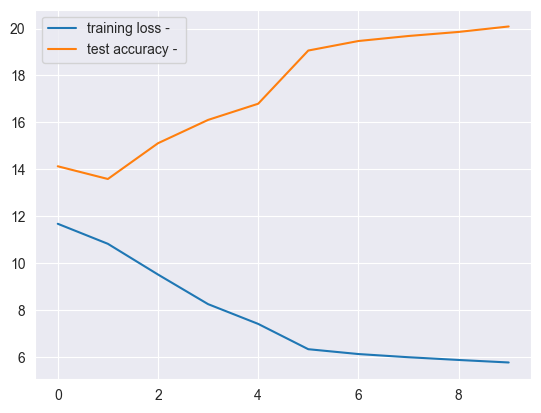

In [24]:
test_accs, top_k_accs, losses, best_model, best_acc, test_loader = train(args) 

print(test_accs, top_k_accs)
print("Maximum test set accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))

# plt.title(dataset.name)
plt.plot(losses, label="training loss" + " - ")
plt.plot(test_accs, label="test accuracy" + " - ")
plt.legend()
plt.show()

In [25]:
# Save the best model
torch.save(best_model.state_dict(), 'model')

In [25]:
# Run test for our best model to save the predictions!
train_dataset = GraphDataset('./', 'train')
train_loader = pyg_data.DataLoader(train_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  drop_last=True)

test(train_loader, best_model, is_validation=False, save_model_preds=True)

C:\Users\USER\Desktop\ML viva\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 2919/2919 [58:54<00:00,  1.21s/it] 


(32.29496402877698, 70.33059266872216)

In [29]:
# Run test for our best model to save the predictions!
test_dataset = GraphDataset('./', 'test')
test_loader = pyg_data.DataLoader(test_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=False,
                                  drop_last=True)

test(test_loader, best_model, is_validation=False, save_model_preds=True)

C:\Users\USER\Desktop\ML viva\.venv\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
100%|██████████| 70/70 [01:24<00:00,  1.21s/it]


(31.7, 70.14285714285714)

In [23]:
import torch
import torch.nn as nn

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = model = SRGNN(args.hidden_dim, args.num_items).to(device)

# Load the state dictionary into the model
best_model.load_state_dict(torch.load('model_full', map_location=device))

# Set the model to evaluation mode
best_model.eval()

#best_model.to('cuda')

SRGNN(
  (embedding): Embedding(466868, 64)
  (gated): GatedSessionGraphConv()
  (q): Linear(in_features=64, out_features=1, bias=True)
  (W_1): Linear(in_features=64, out_features=64, bias=False)
  (W_2): Linear(in_features=64, out_features=64, bias=True)
  (W_3): Linear(in_features=128, out_features=64, bias=False)
)

In [1]:
import pickle
import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the preprocessed data
with open('raw/train.txt', 'rb') as f:
    train_sessions = pickle.load(f)
with open('raw/val.txt', 'rb') as f:
    val_sessions = pickle.load(f)
with open('raw/test.txt', 'rb') as f:
    test_sessions = pickle.load(f)

# Combine all sessions
all_sessions = train_sessions + val_sessions + test_sessions

def generate_recommendations(visitor_id, sessions, model, top_k=10):
    # Filter sessions for the given visitor ID
    user_sessions = [session for session in sessions if session[0] == visitor_id]
    if not user_sessions:
        return "No sessions found for the given visitor ID."

    # Generate recommendations using the model
    recommendations = []
    for session in user_sessions:
        if len(session) < 2:
            continue  # Ensure session has enough elements
        session_data = np.array(session[1:])  # Convert to NumPy array for factorization

        # Build Data instance
        codes, uniques = pd.factorize(session_data)
        senders, receivers = codes[:-1], codes[1:]
        if len(senders) == 0 or len(receivers) == 0:
            continue  # Skip if there are no edges

        edge_index = torch.tensor(np.array([senders, receivers]), dtype=torch.long).to(device)
        x = torch.tensor(codes, dtype=torch.long).unsqueeze(1).to(device)
        batch = torch.zeros(len(codes), dtype=torch.long).to(device)

        data = Data(x=x, edge_index=edge_index, batch=batch)

        with torch.no_grad():
            output = model(data)
            if output.numel() < top_k:
                top_k = output.numel()  # Adjust top_k if not enough predictions
            top_items = torch.topk(output.squeeze(), top_k).indices.tolist()
            recommendations.extend(top_items)

    # Flatten and get unique recommendations
    unique_recommendations = list(set(recommendations))
    return unique_recommendations[:top_k]

# Example usage
visitor_id = 1234
recommendations = generate_recommendations(visitor_id, all_sessions, best_model, top_k=5)
print("Top 10 Recommended Items:", recommendations)

NameError: name 'best_model' is not defined